In [1]:
import os
import glob
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
import sklearn as sklearn
import random

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#loading datasets
class NpyImageDataset(Dataset):
    """
    General dataset for loading .npy image files from a directory structure.
    Assumes that each class has its own subdirectory.
    """
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (str): Root directory containing subdirectories for each class.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # List all subdirectories (each is a class)
        class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
        # Create a mapping from class name to integer index
        self.class_to_idx = {class_name: i for i, class_name in enumerate(sorted(class_dirs))}
        
        # Collect all .npy files and assign labels based on folder
        for class_name in class_dirs:
            class_path = os.path.join(data_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            for file_path in glob.glob(os.path.join(class_path, '*.npy')):
                self.image_paths.append(file_path)
                self.labels.append(class_idx)
                
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image from .npy file
        image = np.load(self.image_paths[idx])
        label = self.labels[idx]
        image = torch.from_numpy(image).float()
        # If image is 2D (H x W), add a channel dimension.
        if image.dim() == 2:
            image = image.unsqueeze(0)
        if self.transform:
            image = self.transform(image)
        return image, label

class FilteredNpyImageDataset(Dataset):
    """
    Dataset that filters the samples from NpyImageDataset to only include one target class.
    This is used for pretraining the MAE on the 'no_sub' samples.
    """
    def __init__(self, data_dir, target_class, transform=None):
        base_dataset = NpyImageDataset(data_dir, transform=transform)
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = base_dataset.class_to_idx
        target_idx = self.class_to_idx[target_class]
        # Filter for only those samples whose label matches target_idx
        for path, label in zip(base_dataset.image_paths, base_dataset.labels):
            if label == target_idx:
                self.image_paths.append(path)
                self.labels.append(label)
                
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        label = self.labels[idx]
        image = torch.from_numpy(image).float()
        if image.dim() == 2:
            image = image.unsqueeze(0)
        if self.transform:
            image = self.transform(image)
        return image, label

class NpySuperResolutionDataset(Dataset):
    """
    Dataset for the super-resolution task.
    Expects that low-resolution (LR) and high-resolution (HR) .npy images are stored
    in separate directories but with matching filenames.
    """
    def __init__(self, lr_dir, hr_dir, transform_lr=None, transform_hr=None):
        self.lr_paths = sorted(glob.glob(os.path.join(lr_dir, '*.npy')))
        self.hr_paths = sorted(glob.glob(os.path.join(hr_dir, '*.npy')))
        assert len(self.lr_paths) == len(self.hr_paths), "Mismatch in number of LR and HR files"
        self.transform_lr = transform_lr
        self.transform_hr = transform_hr

    def __len__(self):
        return len(self.lr_paths)

    def __getitem__(self, idx):
        lr = np.load(self.lr_paths[idx])
        hr = np.load(self.hr_paths[idx])
        lr = torch.from_numpy(lr).float()
        hr = torch.from_numpy(hr).float()
        if lr.dim() == 2:
            lr = lr.unsqueeze(0)
        if hr.dim() == 2:
            hr = hr.unsqueeze(0)
        if self.transform_lr:
            lr = self.transform_lr(lr)
        if self.transform_hr:
            hr = self.transform_hr(hr)
        return lr, hr


In [3]:
def apply_patch_mask(img, mask_ratio=0.75, patch_size=16):
    """
    Applies a patch-level mask to an image.
    Divides the image (C, H, W) into patches of size patch_size x patch_size,
    randomly masks a fraction (mask_ratio) of the patches (sets them to 0),
    and returns both the masked image and the binary mask.
    """
    C, H, W = img.shape
    # Ensure H and W are divisible by patch_size
    assert H % patch_size == 0 and W % patch_size == 0, "Image dimensions must be divisible by patch_size"
    grid_h, grid_w = H // patch_size, W // patch_size
    # Create a mask for each patch (True if the patch is to be masked)
    patch_mask = (torch.rand(grid_h, grid_w) < mask_ratio)
    # Expand patch mask to pixel resolution
    mask = patch_mask.unsqueeze(0).repeat(C, 1, 1)
    mask = mask.repeat_interleave(patch_size, dim=1).repeat_interleave(patch_size, dim=2)
    # Create masked image: set masked pixels to 0
    img_masked = img.clone()
    img_masked[mask] = 0.0
    return img_masked, mask

In [4]:
class MAE(nn.Module):
    """
    A simple Masked Autoencoder model.
    The encoder is a small convolutional network and the decoder upsamples back to the original resolution.
    The model is trained to reconstruct only the masked portions of the input.
    """
    def __init__(self, in_channels=1, latent_dim=128):
        super(MAE, self).__init__()
        # Encoder: 3 conv layers with downsampling
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),   # -> (32, H/2, W/2)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),              # -> (64, H/4, W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, latent_dim, kernel_size=3, stride=2, padding=1),        # -> (latent_dim, H/8, W/8)
            nn.BatchNorm2d(latent_dim),
            nn.ReLU(),
        )
        # Decoder: 3 transposed conv layers for upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (64, H/4, W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0),           # -> (32, H/2, W/2)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),    # -> (in_channels, H, W)
            nn.Sigmoid()  # To constrain outputs to [0, 1]
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon, latent

In [5]:
class ClassificationModel(nn.Module):
    """
    classification model with standard blocks.
    Uses dropout and batch normalization for better generalization.
    """
    def __init__(self, encoder, latent_dim=128, num_classes=3):
        super(ClassificationModel, self).__init__()
        #using the pretrained encoder
        self.encoder = encoder  
        
        #adding a few additional layers to adapt the encoder features
        self.adapt_layers = nn.Sequential(
            nn.Conv2d(latent_dim, latent_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(latent_dim),
            nn.ReLU(),
            nn.Conv2d(latent_dim, latent_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(latent_dim),
            nn.ReLU()
        )
        
        #global average pooling followed by classifier head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        #classifier head with dropout for regularization
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),  #dropout for regularization
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        features = self.encoder(x)
        features = self.adapt_layers(features)
        #global average pooling
        pooled = self.avgpool(features)
        #classification
        output = self.classifier(pooled)
        return output

In [6]:
class SuperResolutionModel(nn.Module):
    def __init__(self, encoder, latent_dim=128, in_channels=1, lr_size=(80, 80), hr_size=(150, 150)):
        super(SuperResolutionModel, self).__init__()
        self.encoder = encoder  #using pretrained encoder
        self.lr_size = lr_size
        self.hr_size = hr_size
        
        self.scale_factor = hr_size[0] / (lr_size[0] // 8)  #enoder downsamples by 8x
        
        #feature processing
        self.process_features = nn.Sequential(
            nn.Conv2d(latent_dim, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        #progressive upsampling to target size
        self.upsampler = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 2x upscale
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2x upscale
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 2x upscale
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        #final layer to adjust channel count and apply final adjustments
        self.final = nn.Sequential(
            nn.Conv2d(32, in_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        features = self.encoder(x)
        processed = self.process_features(features)
        
        
        #upsample progressively
        upsampled = self.upsampler(processed)


        out = self.final(upsampled)
        
        #resize to target HR size if needed
        if out.shape[2:] != self.hr_size:
            out = F.interpolate(out, size=self.hr_size, mode='bilinear', align_corners=False)
            
        return out

In [7]:
class MaskGenerator(nn.Module):
    """
    Adversarially-trained mask generator that predicts which patches contain higher information density.
    Uses the Gumbel-Softmax trick for differentiable mask sampling.
    """
    def __init__(self, in_channels=1, patch_size=16, hidden_dim=64):
        super(MaskGenerator, self).__init__()
        self.patch_size = patch_size
        
        # Downsampling network to process the image
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
        )
        
        # Final layer to predict patch importance scores
        self.score_predictor = nn.Conv2d(hidden_dim, 1, kernel_size=1)
        
        # Temperature parameter for Gumbel-Softmax
        self.temperature = nn.Parameter(torch.ones(1) * 1.0)

    def forward(self, x, mask_ratio=0.75, hard=True):
        """
        Args:
            x: Input image [B, C, H, W]
            mask_ratio: Ratio of patches to mask
            hard: Whether to use hard (True) or soft (False) sampling
            
        Returns:
            patch_mask: Binary mask at patch level [B, 1, H/patch_size, W/patch_size]
            pixel_mask: Binary mask at pixel level [B, C, H, W]
        """
        B, C, H, W = x.shape
        
        # Ensure dimensions are divisible by patch_size
        assert H % self.patch_size == 0 and W % self.patch_size == 0, "Image dimensions must be divisible by patch_size"
        
        # Number of patches in each dimension
        num_patches_h = H // self.patch_size
        num_patches_w = W // self.patch_size
        
        # Convert to patches
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(B, C, num_patches_h, num_patches_w, self.patch_size, self.patch_size)
        
        # Process the image to get patch importance scores
        features = self.encoder(x)
        
        # Resize features to match patch grid
        if features.shape[2:] != (num_patches_h, num_patches_w):
            features = F.adaptive_avg_pool2d(features, (num_patches_h, num_patches_w))
        
        # Generate importance scores for each patch
        patch_scores = self.score_predictor(features).squeeze(1)  # [B, H/patch_size, W/patch_size]
        
        # We want to mask patches with high scores (more informative)
        # Calculate how many patches to keep (unmask)
        num_keep = int((1 - mask_ratio) * num_patches_h * num_patches_w)
        
        if hard:
            # Gumbel-Softmax trick for differentiable sampling
            gumbel_noise = -torch.log(-torch.log(torch.rand_like(patch_scores) + 1e-10) + 1e-10)
            perturbed_scores = patch_scores + gumbel_noise * self.temperature
            
            # Find the top-k patches to keep (unmask)
            _, indices = torch.topk(perturbed_scores.reshape(B, -1), num_keep, dim=1)
            
            # Create binary mask (1 = keep, 0 = mask)
            patch_mask = torch.zeros_like(patch_scores.reshape(B, -1))
            patch_mask.scatter_(1, indices, 1.0)
            patch_mask = patch_mask.reshape(B, num_patches_h, num_patches_w)
        else:
            # Soft masking using sigmoid activation
            patch_mask = torch.sigmoid(patch_scores)
            # Adjust the threshold to match the desired mask ratio
            threshold = torch.topk(patch_mask.reshape(B, -1), num_keep, dim=1)[0][:, -1].view(B, 1, 1)
            patch_mask = (patch_mask >= threshold).float()
        
        # Expand patch mask to full resolution
        pixel_mask = patch_mask.unsqueeze(1)  # [B, 1, H/patch_size, W/patch_size]
        pixel_mask = pixel_mask.repeat_interleave(self.patch_size, dim=2).repeat_interleave(self.patch_size, dim=3)
        
        # Repeat across channels
        if pixel_mask.shape[1] != C:
            pixel_mask = pixel_mask.repeat(1, C, 1, 1)
            
        return 1 - patch_mask, 1 - pixel_mask  # Invert mask (1 = mask, 0 = keep)

class MAE_LearnMask(nn.Module):
    """
    AutoMAE: Masked Autoencoder with learnable masking strategy.
    Integrates a mask generator that learns to identify patches with higher information density.
    """
    def __init__(self, in_channels=1, latent_dim=128, patch_size=16):
        super(MAE_LearnMask, self).__init__()
        self.patch_size = patch_size
        
        # Mask generator network
        self.mask_generator = MaskGenerator(in_channels=in_channels, patch_size=patch_size)
        
        # Encoder (same as original MAE)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),   # -> (32, H/2, W/2)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),              # -> (64, H/4, W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, latent_dim, kernel_size=3, stride=2, padding=1),        # -> (latent_dim, H/8, W/8)
            nn.BatchNorm2d(latent_dim),
            nn.ReLU(),
        )
        
        # Decoder (same as original MAE)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (64, H/4, W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0),           # -> (32, H/2, W/2)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),    # -> (in_channels, H, W)
            nn.Sigmoid()  # To constrain outputs to [0, 1]
        )
        
    def forward(self, x, mask_ratio=0.75, use_generated_mask=True):
        batch_size = x.shape[0]
        
        # Generate masks or use random masking
        if use_generated_mask:
            _, pixel_masks = self.mask_generator(x, mask_ratio=mask_ratio)
            masked_images = x * (1 - pixel_masks)  # Apply mask (0 = masked)
        else:
            # Fall back to random masking for comparison
            masked_images, pixel_masks = [], []
            for i in range(batch_size):
                img_masked, mask = apply_patch_mask(x[i], mask_ratio, self.patch_size)
                masked_images.append(img_masked)
                pixel_masks.append(mask)
            masked_images = torch.stack(masked_images)
            pixel_masks = torch.stack(pixel_masks)
        
        # Encode masked images
        latent = self.encoder(masked_images)
        
        # Decode to reconstruct full images
        recon = self.decoder(latent)
        
        return recon, latent, masked_images, pixel_masks

In [8]:
def train_mae_learn(model, dataloader, num_epochs=20, device='cuda', mask_ratio=0.75, patch_size=16, 
                   alpha=0.1, alternate_epochs=2):
    """
    Train AutoMAE with learnable masking strategy.
    
    Args:
        model: MAE_LearnMask model
        dataloader: DataLoader containing training images
        num_epochs: Number of training epochs
        device: Device to train on
        mask_ratio: Ratio of patches to mask
        patch_size: Size of each patch
        alpha: Weight for adversarial loss
        alternate_epochs: Number of epochs to alternate between training modes
        
    Returns:
        Trained model
    """
    model.train()
    model.to(device)
    
    # Two separate optimizers - one for reconstruction task and one for mask generator
    mae_optimizer = optim.Adam([
        {'params': model.encoder.parameters()},
        {'params': model.decoder.parameters()},
    ], lr=1e-3)
    
    mask_optimizer = optim.Adam(model.mask_generator.parameters(), lr=1e-4)
    
    # Loss functions
    mse_loss = nn.MSELoss(reduction='none')
    
    # Tracking metrics
    history = {'recon_loss': [], 'mask_loss': [], 'total_loss': []}
    
    for epoch in range(num_epochs):
        running_recon_loss = 0.0
        running_mask_loss = 0.0
        running_total_loss = 0.0
        
        # Decide whether to update mask generator this epoch
        update_mask_generator = (epoch % (2 * alternate_epochs)) < alternate_epochs
        
        for images, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - {'Mask Update' if update_mask_generator else 'MAE Update'}"):
            images = images.to(device)
            
            # Forward pass
            recon, _, masked_images, masks = model(images, mask_ratio=mask_ratio)
            
            # Resize reconstruction to match original image size if dimensions don't match
            if recon.shape != images.shape:
                recon = F.interpolate(recon, size=(images.shape[2], images.shape[3]), 
                                    mode='bilinear', align_corners=False)
            
            # Base reconstruction loss (pixel-wise MSE on masked regions)
            loss_map = mse_loss(recon, images)
            recon_loss = (loss_map * masks).sum() / masks.sum()
            
            # Adversarial loss for mask generator (maximize information gain)
            # We measure this as the reconstruction difficulty on masked regions
            mask_loss = -recon_loss * alpha
            
            # Combined loss depends on current training mode
            if update_mask_generator:
                total_loss = mask_loss
                mae_optimizer.zero_grad()
                mask_optimizer.zero_grad()
                total_loss.backward()
                mask_optimizer.step()
            else:
                total_loss = recon_loss
                mae_optimizer.zero_grad()
                mask_optimizer.zero_grad()
                total_loss.backward()
                mae_optimizer.step()
            
            # Track losses
            running_recon_loss += recon_loss.item() * images.size(0)
            running_mask_loss += mask_loss.item() * images.size(0)
            running_total_loss += total_loss.item() * images.size(0)
        
        # Compute epoch losses
        epoch_recon_loss = running_recon_loss / len(dataloader.dataset)
        epoch_mask_loss = running_mask_loss / len(dataloader.dataset)
        epoch_total_loss = running_total_loss / len(dataloader.dataset)
        
        # Update history
        history['recon_loss'].append(epoch_recon_loss)
        history['mask_loss'].append(epoch_mask_loss)
        history['total_loss'].append(epoch_total_loss)
        
        print(f"[AutoMAE] Epoch [{epoch+1}/{num_epochs}], "
              f"Recon Loss: {epoch_recon_loss:.6f}, Mask Loss: {epoch_mask_loss:.6f}, "
              f"Total Loss: {epoch_total_loss:.6f}, "
              f"Mode: {'Mask Update' if update_mask_generator else 'MAE Update'}")
        
    # Visualize the results and mask examples
    visualize_automae_results(model, dataloader, device, mask_ratio)
    
    # Plot training history
    plt.figure(figsize=(10, 4))
    plt.plot(history['recon_loss'], label='Reconstruction Loss')
    plt.plot([-l for l in history['mask_loss']], label='Mask Generator Loss (negated)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('AutoMAE Training History')
    plt.savefig('automae_training_history.png')
    plt.show()
    
    return model

def visualize_automae_results(model, dataloader, device, mask_ratio=0.75):
    """Visualize AutoMAE results with both learned and random masks"""
    model.eval()
    with torch.no_grad():
        for images, _ in dataloader:
            # Select 5 random images from the batch
            indices = random.sample(range(images.shape[0]), 5)
            originals = [images[i] for i in indices]
            images = images.to(device)
            
            # Get reconstructions with learned masks
            recon_learned, _, masked_learned, _ = model(images[indices], mask_ratio=mask_ratio)
            
            # Get reconstructions with random masks
            recon_random, _, masked_random, _ = model(images[indices], mask_ratio=mask_ratio, use_generated_mask=False)
            
            # Display results
            fig, axes = plt.subplots(5, 5, figsize=(15, 15))
            for i in range(5):
                # Original image
                axes[i, 0].imshow(originals[i].squeeze().cpu(), cmap='gray')
                axes[i, 0].set_title("Original")
                axes[i, 0].axis('off')
                
                # Learned mask
                axes[i, 1].imshow(masked_learned[i].squeeze().cpu(), cmap='gray')
                axes[i, 1].set_title("Learned Mask")
                axes[i, 1].axis('off')
                
                # Learned mask reconstruction
                axes[i, 2].imshow(recon_learned[i].squeeze().cpu(), cmap='gray')
                axes[i, 2].set_title("Recon (Learned)")
                axes[i, 2].axis('off')
                
                # Random mask
                axes[i, 3].imshow(masked_random[i].squeeze().cpu(), cmap='gray')
                axes[i, 3].set_title("Random Mask")
                axes[i, 3].axis('off')
                
                # Random mask reconstruction
                axes[i, 4].imshow(recon_random[i].squeeze().cpu(), cmap='gray')
                axes[i, 4].set_title("Recon (Random)")
                axes[i, 4].axis('off')
                
            plt.tight_layout()
            plt.savefig('automae_visualization.png')
            plt.show()
            break

In [9]:
def train_mae(model, dataloader, num_epochs=20, device='cuda', mask_ratio=0.75, patch_size=16):
    """
    Train the MAE model using masked reconstruction loss (MSE computed only on masked pixels).
    """
    model.train()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    # We use MSELoss but will manually weight the loss on masked regions.
    mse_loss = nn.MSELoss(reduction='none')
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            # Apply patch masking to each image in the batch
            masked_images = []
            masks = []
            for img in images:
                img_masked, mask = apply_patch_mask(img, mask_ratio, patch_size)
                masked_images.append(img_masked)
                masks.append(mask)
            masked_images = torch.stack(masked_images).to(device)
            masks = torch.stack(masks).to(device)
            
            optimizer.zero_grad()
            recon, _ = model(masked_images)
            # Resize reconstruction to match original image size if dimensions don't match
            if recon.shape != images.shape:
                recon = F.interpolate(recon, size=(images.shape[2], images.shape[3]), mode='bilinear', align_corners=False)
            # Compute loss only on masked pixels
            loss_map = mse_loss(recon, images)
            loss = (loss_map * masks).sum() / masks.sum()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"[MAE Pretraining] Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")
        
    # Visualize 5 random examples: original, masked, and reconstructed images
    model.eval()
    with torch.no_grad():
        for images, _ in dataloader:
            # Select 5 random images from the batch
            indices = random.sample(range(images.shape[0]), 5)
            originals, masked, reconstructions = [], [], []
            for i in indices:
                img = images[i].to(device)
                img_masked, _ = apply_patch_mask(img, mask_ratio, patch_size)
                output, _ = model(img_masked.unsqueeze(0))
                # Resize if necessary to match original image dimensions
                if output.shape != img.unsqueeze(0).shape:
                    output = F.interpolate(output, size=(img.shape[1], img.shape[2]), mode='bilinear', align_corners=False)
                originals.append(img.cpu())
                masked.append(img_masked.cpu())
                reconstructions.append(output.squeeze(0).cpu())
            break

    fig, axes = plt.subplots(5, 3, figsize=(12, 20))
    for i in range(5):
        axes[i, 0].imshow(originals[i].squeeze(), cmap='gray')
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')
        axes[i, 1].imshow(masked[i].squeeze(), cmap='gray')
        axes[i, 1].set_title("Masked")
        axes[i, 1].axis('off')
        axes[i, 2].imshow(reconstructions[i].squeeze(), cmap='gray')
        axes[i, 2].set_title("Reconstructed")
        axes[i, 2].axis('off')
    plt.tight_layout()
    plt.show()
    # save image
    plt.savefig('reconstruction_results.png')
    return model


In [10]:
def train_classifier(model, train_loader, val_loader, num_epochs=10, device='cuda'):
    """
    Improved training function for the classifier with learning rate scheduling,
    early stopping, and model checkpointing.
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    # Use SGD with momentum instead of Adam for better convergence
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    
    # Learning rate scheduler - reduce LR when plateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
    
    best_auc = 0.0
    best_model_state = None
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            running_loss += loss.item() * images.size(0)
            
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100.0 * correct / total
        
        # Validation phase
        model.eval()
        all_labels = []
        all_probs = []
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                
                # Calculate accuracy
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                
                # For AUC calculation
                probs = torch.softmax(outputs, dim=1)
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100.0 * val_correct / val_total
        
        # Convert ground truth to one-hot encoding for roc_auc_score
        num_classes = len(set(all_labels))
        one_hot_labels = np.eye(num_classes)[np.array(all_labels)]
        try:
            auc_score = roc_auc_score(one_hot_labels, np.array(all_probs), average='macro')
        except Exception as e:
            print(f"Warning: Error calculating AUC: {str(e)}")
            auc_score = 0.0
        
        # Print metrics
        print(f"[Classifier] Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
              f"ROC AUC: {auc_score:.4f}")
        
        # Update learning rate based on AUC
        scheduler.step(auc_score)
        
        # Check if this is the best model (based on AUC)
        if auc_score > best_auc:
            best_auc = auc_score
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load the best model weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with AUC: {best_auc:.4f}")
    
    return model

In [11]:
def visualize_classifier_roc_auc(model, test_loader, num_classes=3, device='cuda'):
    """
    Visualizes ROC curves and calculates AUC for each class in a classifier model.
    
    Args:
        model: The trained classifier model
        test_loader: DataLoader containing test/validation data
        num_classes: Number of classes in the classification task
        device: Device to run inference on
    """
    model.eval()
    
    # Collect all predictions and true labels
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Generating predictions"):
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())
    
    # Concatenate batches
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # One-hot encode true labels for ROC calculation
    true_labels_one_hot = np.zeros((all_labels.size, num_classes))
    for i in range(all_labels.size):
        true_labels_one_hot[i, all_labels[i]] = 1
    
    # Calculate ROC curves and AUC for each class
    plt.figure(figsize=(10, 8))
    
    class_auc_scores = []
    
    # For micro-average ROC curve
    all_probs_flat = all_probs.ravel()
    all_labels_flat = true_labels_one_hot.ravel()
    
    for i in range(num_classes):
        # Calculate ROC curve for this class
        fpr, tpr, _ = sklearn.metrics.roc_curve(true_labels_one_hot[:, i], all_probs[:, i])
        
        # Calculate AUC
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        class_auc_scores.append(roc_auc)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')
    
    # Calculate and plot micro-average ROC curve
    fpr_micro, tpr_micro, _ = sklearn.metrics.roc_curve(all_labels_flat, all_probs_flat)
    roc_auc_micro = sklearn.metrics.auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, lw=2, linestyle='--',
             label=f'Micro-average (AUC = {roc_auc_micro:.3f})')
    
    # Calculate and report macro-average AUC
    macro_roc_auc = np.mean(class_auc_scores)
    
    # Plot diagonal line for random classifier
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multi-Class Classification')
    plt.legend(loc="lower right")
    
    # Add text with macro-average AUC
    plt.text(0.7, 0.3, f'Macro-average AUC: {macro_roc_auc:.3f}', 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('classifier_roc_auc.png', dpi=300)
    plt.show()
    
    # Print AUC scores in table format
    print("\nAUC Scores:")
    print("-" * 30)
    print(f"{'Class':<10} | {'AUC Score':<10}")
    print("-" * 30)
    for i, score in enumerate(class_auc_scores):
        print(f"{i:<10} | {score:.4f}")
    print("-" * 30)
    print(f"{'Micro-avg':<10} | {roc_auc_micro:.4f}")
    print(f"{'Macro-avg':<10} | {macro_roc_auc:.4f}")
    
    return class_auc_scores, roc_auc_micro, macro_roc_auc

In [12]:
def train_super_resolution(model, dataloader, num_epochs=10, device='cuda'):
    """
    Improved training function for super-resolution with L1 loss component
    and proper handling of output size.
    """
    model.to(device)
    # Combine MSE and L1 loss for better results
    mse_criterion = nn.MSELoss()
    l1_criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=2e-4, betas=(0.9, 0.999))
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    
    for epoch in range(num_epochs):
        model.train()
        running_mse_loss = 0.0
        running_l1_loss = 0.0
        running_total_loss = 0.0
        
        for lr_imgs, hr_imgs in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            
            optimizer.zero_grad()
            outputs = model(lr_imgs)
            
            # Ensure output size matches target size
            if outputs.shape != hr_imgs.shape:
                outputs = F.interpolate(outputs, size=(hr_imgs.shape[2], hr_imgs.shape[3]), 
                                        mode='bilinear', align_corners=False)
                
            # Calculate losses
            mse_loss = mse_criterion(outputs, hr_imgs)
            l1_loss = l1_criterion(outputs, hr_imgs)
            # Combined loss (MSE with L1 regularization)
            loss = mse_loss + 0.5 * l1_loss
            
            loss.backward()
            optimizer.step()
            
            # Track metrics
            running_mse_loss += mse_loss.item() * lr_imgs.size(0)
            running_l1_loss += l1_loss.item() * lr_imgs.size(0)
            running_total_loss += loss.item() * lr_imgs.size(0)
            
        # Compute epoch losses
        epoch_mse_loss = running_mse_loss / len(dataloader.dataset)
        epoch_l1_loss = running_l1_loss / len(dataloader.dataset)
        epoch_total_loss = running_total_loss / len(dataloader.dataset)
        
        # PSNR calculation (assuming images normalized in [0,1])
        psnr = 10 * math.log10(1.0 / (epoch_mse_loss + 1e-8))
        
        # Update learning rate
        scheduler.step()
        
        print(f"[Super-Resolution] Epoch [{epoch+1}/{num_epochs}], "
              f"MSE Loss: {epoch_mse_loss:.6f}, L1 Loss: {epoch_l1_loss:.6f}, "
              f"Total Loss: {epoch_total_loss:.6f}, PSNR: {psnr:.2f} dB")
    
    # Visualize a few examples
    model.eval()
    with torch.no_grad():
        for lr_imgs, hr_imgs in dataloader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            
            # Ensure correct size for visualization
            if sr_imgs.shape != hr_imgs.shape:
                sr_imgs = F.interpolate(sr_imgs, size=(hr_imgs.shape[2], hr_imgs.shape[3]), 
                                        mode='bilinear', align_corners=False)
            
            # Pick a few samples to visualize
            n_samples = min(3, lr_imgs.size(0))
            
            fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))
            for i in range(n_samples):
                # Low-resolution input
                axes[i, 0].imshow(lr_imgs[i].cpu().squeeze(0), cmap='gray')
                axes[i, 0].set_title("Low Resolution")
                axes[i, 0].axis('off')
                
                # Super-resolution output
                axes[i, 1].imshow(sr_imgs[i].cpu().squeeze(0), cmap='gray')
                axes[i, 1].set_title("Super Resolution")
                axes[i, 1].axis('off')
                
                # High-resolution ground truth
                axes[i, 2].imshow(hr_imgs[i].cpu().squeeze(0), cmap='gray')
                axes[i, 2].set_title("High Resolution")
                axes[i, 2].axis('off')
            
            plt.tight_layout()
            plt.show()
            plt.savefig('super_resolution_results.png')
            break
            
    return model

Using device: cuda
Starting MAE pretraining...


Epoch 1/50: 100%|██████████| 157/157 [00:18<00:00,  8.55it/s]


[MAE Pretraining] Epoch [1/50], Loss: 0.009895


Epoch 2/50: 100%|██████████| 157/157 [00:09<00:00, 15.82it/s]


[MAE Pretraining] Epoch [2/50], Loss: 0.001287


Epoch 3/50: 100%|██████████| 157/157 [00:09<00:00, 15.83it/s]


[MAE Pretraining] Epoch [3/50], Loss: 0.001025


Epoch 4/50: 100%|██████████| 157/157 [00:10<00:00, 15.66it/s]


[MAE Pretraining] Epoch [4/50], Loss: 0.000849


Epoch 5/50: 100%|██████████| 157/157 [00:10<00:00, 15.51it/s]


[MAE Pretraining] Epoch [5/50], Loss: 0.000803


Epoch 6/50: 100%|██████████| 157/157 [00:09<00:00, 15.74it/s]


[MAE Pretraining] Epoch [6/50], Loss: 0.000729


Epoch 7/50: 100%|██████████| 157/157 [00:09<00:00, 15.85it/s]


[MAE Pretraining] Epoch [7/50], Loss: 0.000739


Epoch 8/50: 100%|██████████| 157/157 [00:10<00:00, 15.58it/s]


[MAE Pretraining] Epoch [8/50], Loss: 0.000683


Epoch 9/50: 100%|██████████| 157/157 [00:09<00:00, 15.77it/s]


[MAE Pretraining] Epoch [9/50], Loss: 0.000667


Epoch 10/50: 100%|██████████| 157/157 [00:10<00:00, 15.55it/s]


[MAE Pretraining] Epoch [10/50], Loss: 0.000627


Epoch 11/50: 100%|██████████| 157/157 [00:10<00:00, 15.61it/s]


[MAE Pretraining] Epoch [11/50], Loss: 0.000605


Epoch 12/50: 100%|██████████| 157/157 [00:10<00:00, 15.68it/s]


[MAE Pretraining] Epoch [12/50], Loss: 0.000603


Epoch 13/50: 100%|██████████| 157/157 [00:10<00:00, 15.66it/s]


[MAE Pretraining] Epoch [13/50], Loss: 0.000568


Epoch 14/50: 100%|██████████| 157/157 [00:10<00:00, 15.49it/s]


[MAE Pretraining] Epoch [14/50], Loss: 0.000560


Epoch 15/50: 100%|██████████| 157/157 [00:10<00:00, 15.70it/s]


[MAE Pretraining] Epoch [15/50], Loss: 0.000571


Epoch 16/50: 100%|██████████| 157/157 [00:10<00:00, 15.59it/s]


[MAE Pretraining] Epoch [16/50], Loss: 0.000561


Epoch 17/50: 100%|██████████| 157/157 [00:10<00:00, 15.48it/s]


[MAE Pretraining] Epoch [17/50], Loss: 0.000530


Epoch 18/50: 100%|██████████| 157/157 [00:10<00:00, 15.65it/s]


[MAE Pretraining] Epoch [18/50], Loss: 0.000543


Epoch 19/50: 100%|██████████| 157/157 [00:09<00:00, 15.86it/s]


[MAE Pretraining] Epoch [19/50], Loss: 0.000555


Epoch 20/50: 100%|██████████| 157/157 [00:10<00:00, 15.57it/s]


[MAE Pretraining] Epoch [20/50], Loss: 0.000523


Epoch 21/50: 100%|██████████| 157/157 [00:10<00:00, 15.67it/s]


[MAE Pretraining] Epoch [21/50], Loss: 0.000527


Epoch 22/50: 100%|██████████| 157/157 [00:10<00:00, 15.66it/s]


[MAE Pretraining] Epoch [22/50], Loss: 0.000502


Epoch 23/50: 100%|██████████| 157/157 [00:09<00:00, 15.92it/s]


[MAE Pretraining] Epoch [23/50], Loss: 0.000551


Epoch 24/50: 100%|██████████| 157/157 [00:10<00:00, 15.63it/s]


[MAE Pretraining] Epoch [24/50], Loss: 0.000507


Epoch 25/50: 100%|██████████| 157/157 [00:09<00:00, 15.85it/s]


[MAE Pretraining] Epoch [25/50], Loss: 0.000489


Epoch 26/50: 100%|██████████| 157/157 [00:09<00:00, 15.85it/s]


[MAE Pretraining] Epoch [26/50], Loss: 0.000505


Epoch 27/50: 100%|██████████| 157/157 [00:10<00:00, 15.49it/s]


[MAE Pretraining] Epoch [27/50], Loss: 0.000493


Epoch 28/50: 100%|██████████| 157/157 [00:10<00:00, 15.66it/s]


[MAE Pretraining] Epoch [28/50], Loss: 0.000496


Epoch 29/50: 100%|██████████| 157/157 [00:09<00:00, 15.86it/s]


[MAE Pretraining] Epoch [29/50], Loss: 0.000489


Epoch 30/50: 100%|██████████| 157/157 [00:10<00:00, 15.65it/s]


[MAE Pretraining] Epoch [30/50], Loss: 0.000488


Epoch 31/50: 100%|██████████| 157/157 [00:09<00:00, 15.89it/s]


[MAE Pretraining] Epoch [31/50], Loss: 0.000489


Epoch 32/50: 100%|██████████| 157/157 [00:09<00:00, 15.83it/s]


[MAE Pretraining] Epoch [32/50], Loss: 0.000480


Epoch 33/50: 100%|██████████| 157/157 [00:09<00:00, 15.78it/s]


[MAE Pretraining] Epoch [33/50], Loss: 0.000513


Epoch 34/50: 100%|██████████| 157/157 [00:09<00:00, 15.70it/s]


[MAE Pretraining] Epoch [34/50], Loss: 0.000485


Epoch 35/50: 100%|██████████| 157/157 [00:09<00:00, 15.84it/s]


[MAE Pretraining] Epoch [35/50], Loss: 0.000478


Epoch 36/50: 100%|██████████| 157/157 [00:10<00:00, 15.57it/s]


[MAE Pretraining] Epoch [36/50], Loss: 0.000483


Epoch 37/50: 100%|██████████| 157/157 [00:09<00:00, 15.99it/s]


[MAE Pretraining] Epoch [37/50], Loss: 0.000470


Epoch 38/50: 100%|██████████| 157/157 [00:09<00:00, 15.78it/s]


[MAE Pretraining] Epoch [38/50], Loss: 0.000462


Epoch 39/50: 100%|██████████| 157/157 [00:09<00:00, 15.86it/s]


[MAE Pretraining] Epoch [39/50], Loss: 0.000467


Epoch 40/50: 100%|██████████| 157/157 [00:09<00:00, 15.73it/s]


[MAE Pretraining] Epoch [40/50], Loss: 0.000471


Epoch 41/50: 100%|██████████| 157/157 [00:09<00:00, 15.90it/s]


[MAE Pretraining] Epoch [41/50], Loss: 0.000473


Epoch 42/50: 100%|██████████| 157/157 [00:09<00:00, 15.85it/s]


[MAE Pretraining] Epoch [42/50], Loss: 0.000465


Epoch 43/50: 100%|██████████| 157/157 [00:09<00:00, 15.73it/s]


[MAE Pretraining] Epoch [43/50], Loss: 0.000442


Epoch 44/50: 100%|██████████| 157/157 [00:09<00:00, 15.78it/s]


[MAE Pretraining] Epoch [44/50], Loss: 0.000446


Epoch 45/50: 100%|██████████| 157/157 [00:09<00:00, 15.87it/s]


[MAE Pretraining] Epoch [45/50], Loss: 0.000454


Epoch 46/50: 100%|██████████| 157/157 [00:10<00:00, 15.68it/s]


[MAE Pretraining] Epoch [46/50], Loss: 0.000453


Epoch 47/50: 100%|██████████| 157/157 [00:09<00:00, 15.98it/s]


[MAE Pretraining] Epoch [47/50], Loss: 0.000431


Epoch 48/50: 100%|██████████| 157/157 [00:09<00:00, 15.75it/s]


[MAE Pretraining] Epoch [48/50], Loss: 0.000458


Epoch 49/50: 100%|██████████| 157/157 [00:09<00:00, 15.73it/s]


[MAE Pretraining] Epoch [49/50], Loss: 0.000443


Epoch 50/50: 100%|██████████| 157/157 [00:10<00:00, 15.63it/s]

[MAE Pretraining] Epoch [50/50], Loss: 0.000435


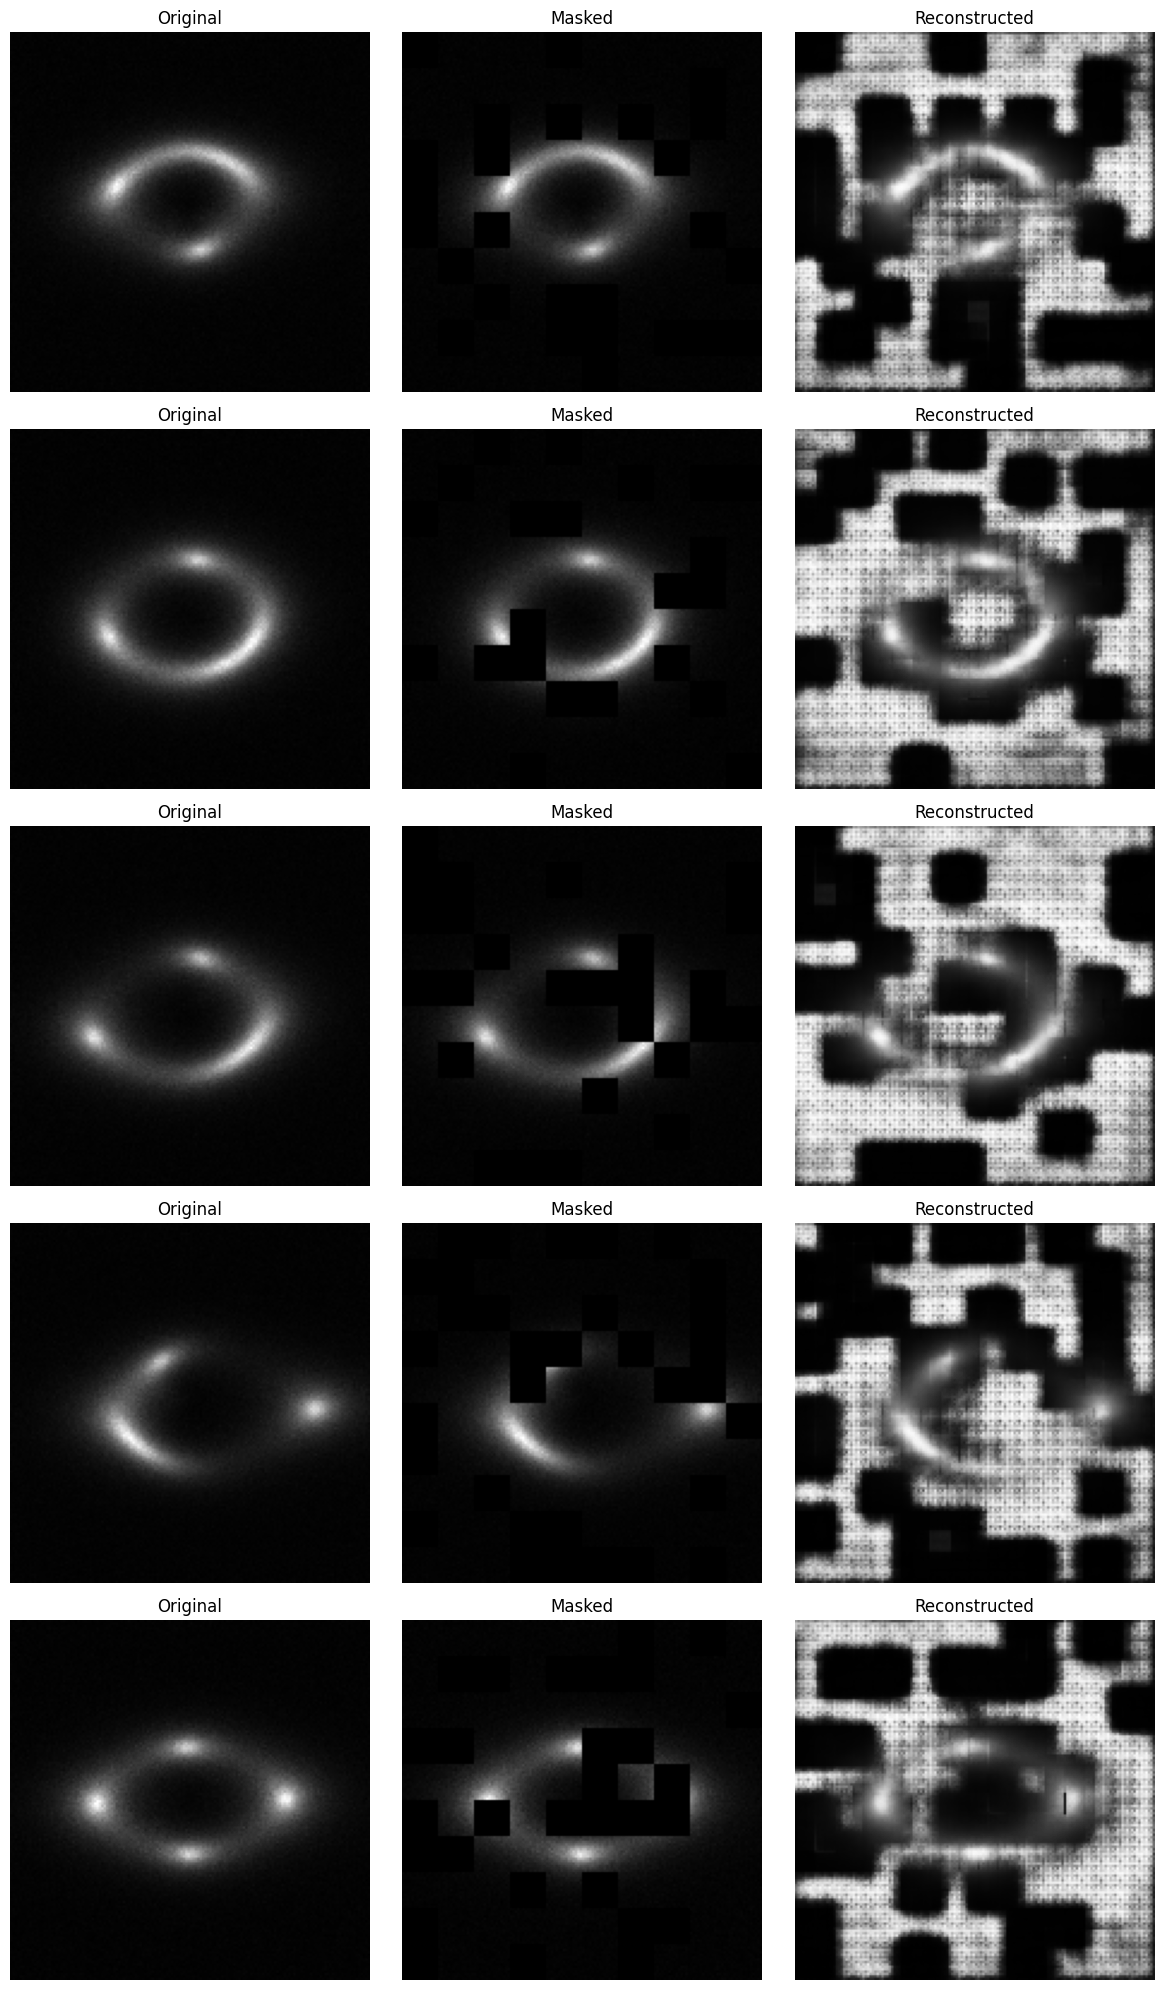

<Figure size 640x480 with 0 Axes>

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

#any necessary transforms (here we assume images are already normalized)
transform = None  

mae_data_dir = '/kaggle/input/deeplense-lensing-classes/dataset/train'  # Should contain subfolders including "no_sub"
target_class = 'no'  # Only use samples with no substructure for pretraining
mae_dataset = FilteredNpyImageDataset(mae_data_dir, target_class=target_class, transform=transform)
mae_loader = DataLoader(mae_dataset, batch_size=64, shuffle=True, num_workers=4)

# Initialize the MAE model (assuming images are single-channel)
mae_model = MAE(in_channels=1, latent_dim=512)
print("Starting MAE pretraining...")
mae_model = train_mae(mae_model, mae_loader, num_epochs=50, device=device, mask_ratio=0.30, patch_size=15)

# Get the pretrained encoder for later use
pretrained_encoder = mae_model.encoder




/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting classifier fine-tuning with frozen encoder...


Epoch 1/50 - Validation: 100%|██████████| 118/118 [00:12<00:00,  9.28it/s]


[Classifier] Epoch [1/50], Train Loss: 1.1111, Train Acc: 33.31%, Val Loss: 1.1047, Val Acc: 33.25%, ROC AUC: 0.4987


Epoch 2/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.31it/s]


[Classifier] Epoch [2/50], Train Loss: 1.1045, Train Acc: 34.08%, Val Loss: 1.1025, Val Acc: 33.41%, ROC AUC: 0.5050


Epoch 3/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.87it/s]


[Classifier] Epoch [3/50], Train Loss: 1.1027, Train Acc: 34.44%, Val Loss: 1.0932, Val Acc: 37.47%, ROC AUC: 0.5444


Epoch 4/50 - Validation: 100%|██████████| 118/118 [00:03<00:00, 35.49it/s]


[Classifier] Epoch [4/50], Train Loss: 1.0935, Train Acc: 36.89%, Val Loss: 1.3662, Val Acc: 33.32%, ROC AUC: 0.5236


Epoch 5/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.29it/s]


[Classifier] Epoch [5/50], Train Loss: 1.0744, Train Acc: 40.18%, Val Loss: 1.0713, Val Acc: 40.71%, ROC AUC: 0.5918


Epoch 6/50 - Validation: 100%|██████████| 118/118 [00:03<00:00, 39.30it/s]


[Classifier] Epoch [6/50], Train Loss: 1.0483, Train Acc: 43.33%, Val Loss: 1.1788, Val Acc: 37.15%, ROC AUC: 0.5907


Epoch 7/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.27it/s]


[Classifier] Epoch [7/50], Train Loss: 1.0217, Train Acc: 45.92%, Val Loss: 1.1243, Val Acc: 38.57%, ROC AUC: 0.6281


Epoch 8/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.27it/s]


[Classifier] Epoch [8/50], Train Loss: 0.9994, Train Acc: 47.86%, Val Loss: 1.1975, Val Acc: 37.60%, ROC AUC: 0.5977


Epoch 9/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.13it/s]


[Classifier] Epoch [9/50], Train Loss: 0.9835, Train Acc: 49.06%, Val Loss: 1.0912, Val Acc: 42.28%, ROC AUC: 0.6358


Epoch 10/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.74it/s]


[Classifier] Epoch [10/50], Train Loss: 0.9621, Train Acc: 50.99%, Val Loss: 2.8353, Val Acc: 33.33%, ROC AUC: 0.6151


Epoch 11/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.13it/s]


[Classifier] Epoch [11/50], Train Loss: 0.9422, Train Acc: 52.15%, Val Loss: 1.0371, Val Acc: 45.79%, ROC AUC: 0.6503


Epoch 12/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.32it/s]


[Classifier] Epoch [12/50], Train Loss: 0.9276, Train Acc: 53.31%, Val Loss: 1.5846, Val Acc: 35.67%, ROC AUC: 0.6181


Epoch 13/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.41it/s]


[Classifier] Epoch [13/50], Train Loss: 0.9125, Train Acc: 54.30%, Val Loss: 1.7943, Val Acc: 34.59%, ROC AUC: 0.6555


Epoch 14/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.75it/s]


[Classifier] Epoch [14/50], Train Loss: 0.8969, Train Acc: 55.12%, Val Loss: 1.0675, Val Acc: 46.95%, ROC AUC: 0.6720


Epoch 15/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.23it/s]


[Classifier] Epoch [15/50], Train Loss: 0.8755, Train Acc: 56.66%, Val Loss: 1.5196, Val Acc: 37.01%, ROC AUC: 0.6756


Epoch 16/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.54it/s]


[Classifier] Epoch [16/50], Train Loss: 0.8614, Train Acc: 57.29%, Val Loss: 1.0336, Val Acc: 50.35%, ROC AUC: 0.7090


Epoch 17/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.85it/s]


[Classifier] Epoch [17/50], Train Loss: 0.8411, Train Acc: 58.91%, Val Loss: 1.2023, Val Acc: 40.75%, ROC AUC: 0.7189


Epoch 18/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.39it/s]


[Classifier] Epoch [18/50], Train Loss: 0.8265, Train Acc: 59.62%, Val Loss: 1.1414, Val Acc: 48.43%, ROC AUC: 0.6958


Epoch 19/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.22it/s]


[Classifier] Epoch [19/50], Train Loss: 0.8133, Train Acc: 60.53%, Val Loss: 2.2611, Val Acc: 36.95%, ROC AUC: 0.6425


Epoch 20/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.92it/s]


[Classifier] Epoch [20/50], Train Loss: 0.7900, Train Acc: 62.36%, Val Loss: 0.9605, Val Acc: 51.99%, ROC AUC: 0.7421


Epoch 21/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.19it/s]


[Classifier] Epoch [21/50], Train Loss: 0.7884, Train Acc: 62.39%, Val Loss: 1.2172, Val Acc: 39.53%, ROC AUC: 0.6979


Epoch 22/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.87it/s]


[Classifier] Epoch [22/50], Train Loss: 0.7678, Train Acc: 64.08%, Val Loss: 1.3428, Val Acc: 45.99%, ROC AUC: 0.7343


Epoch 23/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.07it/s]


[Classifier] Epoch [23/50], Train Loss: 0.7388, Train Acc: 65.50%, Val Loss: 1.3350, Val Acc: 50.55%, ROC AUC: 0.7517


Epoch 24/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.41it/s]


[Classifier] Epoch [24/50], Train Loss: 0.7352, Train Acc: 65.87%, Val Loss: 1.1775, Val Acc: 48.32%, ROC AUC: 0.7296


Epoch 25/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.20it/s]


[Classifier] Epoch [25/50], Train Loss: 0.7142, Train Acc: 67.38%, Val Loss: 3.1590, Val Acc: 34.07%, ROC AUC: 0.7008


Epoch 26/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.37it/s]


[Classifier] Epoch [26/50], Train Loss: 0.6993, Train Acc: 67.86%, Val Loss: 1.5704, Val Acc: 43.71%, ROC AUC: 0.7299


Epoch 27/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.88it/s]


[Classifier] Epoch [27/50], Train Loss: 0.6868, Train Acc: 69.00%, Val Loss: 1.0941, Val Acc: 51.25%, ROC AUC: 0.7504


Epoch 28/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.23it/s]


[Classifier] Epoch [28/50], Train Loss: 0.5988, Train Acc: 73.24%, Val Loss: 1.2759, Val Acc: 56.88%, ROC AUC: 0.7890


Epoch 29/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.58it/s]


[Classifier] Epoch [29/50], Train Loss: 0.5862, Train Acc: 74.24%, Val Loss: 1.6526, Val Acc: 39.31%, ROC AUC: 0.7414


Epoch 30/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.16it/s]


[Classifier] Epoch [30/50], Train Loss: 0.5725, Train Acc: 74.89%, Val Loss: 1.4747, Val Acc: 47.23%, ROC AUC: 0.7694


Epoch 31/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.83it/s]


[Classifier] Epoch [31/50], Train Loss: 0.5698, Train Acc: 75.04%, Val Loss: 3.7848, Val Acc: 34.81%, ROC AUC: 0.6653


Epoch 32/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.25it/s]


[Classifier] Epoch [32/50], Train Loss: 0.5589, Train Acc: 75.50%, Val Loss: 2.3378, Val Acc: 44.73%, ROC AUC: 0.7547


Epoch 33/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.36it/s]


[Classifier] Epoch [33/50], Train Loss: 0.4790, Train Acc: 79.44%, Val Loss: 0.7046, Val Acc: 69.67%, ROC AUC: 0.8660


Epoch 34/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.21it/s]


[Classifier] Epoch [34/50], Train Loss: 0.4710, Train Acc: 80.14%, Val Loss: 2.4487, Val Acc: 35.31%, ROC AUC: 0.7830


Epoch 35/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.19it/s]


[Classifier] Epoch [35/50], Train Loss: 0.4485, Train Acc: 81.01%, Val Loss: 1.0924, Val Acc: 57.20%, ROC AUC: 0.8102


Epoch 36/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.13it/s]


[Classifier] Epoch [36/50], Train Loss: 0.4511, Train Acc: 81.02%, Val Loss: 1.5092, Val Acc: 51.72%, ROC AUC: 0.8089


Epoch 37/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.66it/s]


[Classifier] Epoch [37/50], Train Loss: 0.4395, Train Acc: 81.65%, Val Loss: 1.6168, Val Acc: 56.20%, ROC AUC: 0.7996


Epoch 38/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.20it/s]


[Classifier] Epoch [38/50], Train Loss: 0.3711, Train Acc: 84.81%, Val Loss: 0.6925, Val Acc: 70.51%, ROC AUC: 0.8755


Epoch 39/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.79it/s]


[Classifier] Epoch [39/50], Train Loss: 0.3647, Train Acc: 84.97%, Val Loss: 0.6879, Val Acc: 71.65%, ROC AUC: 0.8818


Epoch 40/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.36it/s]


[Classifier] Epoch [40/50], Train Loss: 0.3479, Train Acc: 85.69%, Val Loss: 0.7635, Val Acc: 69.40%, ROC AUC: 0.8709


Epoch 41/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.17it/s]


[Classifier] Epoch [41/50], Train Loss: 0.3425, Train Acc: 86.04%, Val Loss: 0.8606, Val Acc: 66.73%, ROC AUC: 0.8636


Epoch 42/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.59it/s]


[Classifier] Epoch [42/50], Train Loss: 0.3363, Train Acc: 86.32%, Val Loss: 1.2033, Val Acc: 62.43%, ROC AUC: 0.8428


Epoch 43/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.48it/s]


[Classifier] Epoch [43/50], Train Loss: 0.3262, Train Acc: 86.63%, Val Loss: 1.2093, Val Acc: 59.12%, ROC AUC: 0.8392


Epoch 44/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.65it/s]


[Classifier] Epoch [44/50], Train Loss: 0.2751, Train Acc: 88.87%, Val Loss: 0.7274, Val Acc: 71.95%, ROC AUC: 0.8858


Epoch 45/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.07it/s]


[Classifier] Epoch [45/50], Train Loss: 0.2688, Train Acc: 89.48%, Val Loss: 0.9331, Val Acc: 65.12%, ROC AUC: 0.8804


Epoch 46/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.83it/s]


[Classifier] Epoch [46/50], Train Loss: 0.2579, Train Acc: 89.79%, Val Loss: 0.8373, Val Acc: 70.64%, ROC AUC: 0.8844


Epoch 47/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.46it/s]


[Classifier] Epoch [47/50], Train Loss: 0.2521, Train Acc: 90.22%, Val Loss: 0.9649, Val Acc: 69.93%, ROC AUC: 0.8806


Epoch 48/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.53it/s]


[Classifier] Epoch [48/50], Train Loss: 0.2443, Train Acc: 90.61%, Val Loss: 1.0676, Val Acc: 68.79%, ROC AUC: 0.8772


Epoch 49/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 42.03it/s]


[Classifier] Epoch [49/50], Train Loss: 0.2121, Train Acc: 91.91%, Val Loss: 0.7240, Val Acc: 74.32%, ROC AUC: 0.8963


Epoch 50/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.65it/s]


[Classifier] Epoch [50/50], Train Loss: 0.2065, Train Acc: 92.28%, Val Loss: 0.7664, Val Acc: 72.97%, ROC AUC: 0.8894
Loaded best model with AUC: 0.8963


Generating predictions: 100%|██████████| 118/118 [00:02<00:00, 42.46it/s]


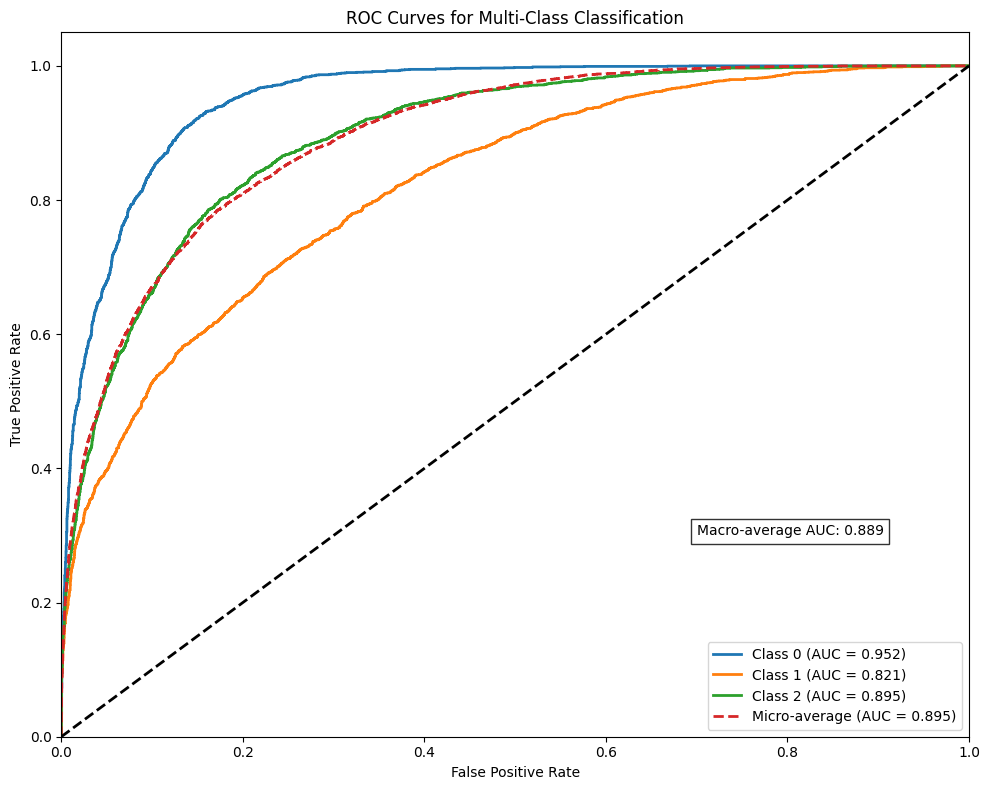


AUC Scores:
------------------------------
Class      | AUC Score 
------------------------------
0          | 0.9519
1          | 0.8215
2          | 0.8949
------------------------------
Micro-avg  | 0.8946
Macro-avg  | 0.8894
[0.9518912399999999, 0.82145976, 0.8949389200000001] 0.8945660177777779 0.8894299733333333


In [14]:

# 6A task

# Full dataset paths for training and validation
train_dir = '/kaggle/input/deeplense-lensing-classes/dataset/train'
val_dir   = '/kaggle/input/deeplense-lensing-classes/dataset/val'
dataset_train = NpyImageDataset(train_dir, transform=transform)
dataset_val   = NpyImageDataset(val_dir, transform=transform)
train_loader_cls = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=4)
val_loader_cls   = DataLoader(dataset_val, batch_size=64, shuffle=False, num_workers=4)

# Build improved classification model using the pretrained encoder
classifier_model = ClassificationModel(encoder=pretrained_encoder, latent_dim=512, num_classes=3)

# Freeze the encoder for a few epochs to allow the new layers to adapt
for param in classifier_model.encoder.parameters():
    param.requires_grad = False

print("Starting classifier fine-tuning with frozen encoder...")
classifier_model = train_classifier(classifier_model, train_loader_cls, val_loader_cls, num_epochs=50, device=device)


class_auc_scores, micro_auc, macro_auc = visualize_classifier_roc_auc(
    classifier_model, 
    val_loader_cls,
    num_classes=3, 
    device=device
)

print(class_auc_scores, micro_auc, macro_auc)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fine-tuning the entire model...


Epoch 1/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.86it/s]


[Classifier] Epoch [1/50], Train Loss: 1.1467, Train Acc: 35.33%, Val Loss: 1.1547, Val Acc: 33.43%, ROC AUC: 0.5503


Epoch 2/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.63it/s]


[Classifier] Epoch [2/50], Train Loss: 1.0361, Train Acc: 44.49%, Val Loss: 2.3219, Val Acc: 33.40%, ROC AUC: 0.6445


Epoch 3/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.89it/s]


[Classifier] Epoch [3/50], Train Loss: 0.8457, Train Acc: 59.55%, Val Loss: 1.5530, Val Acc: 40.73%, ROC AUC: 0.6756


Epoch 4/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.74it/s]


[Classifier] Epoch [4/50], Train Loss: 0.7115, Train Acc: 67.55%, Val Loss: 1.1179, Val Acc: 51.47%, ROC AUC: 0.7904


Epoch 5/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.42it/s]


[Classifier] Epoch [5/50], Train Loss: 0.6453, Train Acc: 71.52%, Val Loss: 1.7199, Val Acc: 48.99%, ROC AUC: 0.7946


Epoch 6/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.79it/s]


[Classifier] Epoch [6/50], Train Loss: 0.5862, Train Acc: 74.66%, Val Loss: 2.3852, Val Acc: 48.59%, ROC AUC: 0.8055


Epoch 7/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.67it/s]


[Classifier] Epoch [7/50], Train Loss: 0.5441, Train Acc: 76.99%, Val Loss: 2.3157, Val Acc: 46.77%, ROC AUC: 0.7785


Epoch 8/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.51it/s]


[Classifier] Epoch [8/50], Train Loss: 0.5022, Train Acc: 78.98%, Val Loss: 1.0776, Val Acc: 59.09%, ROC AUC: 0.8500


Epoch 9/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.51it/s]


[Classifier] Epoch [9/50], Train Loss: 0.4589, Train Acc: 81.31%, Val Loss: 1.1493, Val Acc: 57.83%, ROC AUC: 0.8665


Epoch 10/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.62it/s]


[Classifier] Epoch [10/50], Train Loss: 0.4252, Train Acc: 82.95%, Val Loss: 0.6125, Val Acc: 74.87%, ROC AUC: 0.9221


Epoch 11/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.70it/s]


[Classifier] Epoch [11/50], Train Loss: 0.4031, Train Acc: 83.96%, Val Loss: 0.7297, Val Acc: 68.33%, ROC AUC: 0.9112


Epoch 12/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.65it/s]


[Classifier] Epoch [12/50], Train Loss: 0.3717, Train Acc: 85.26%, Val Loss: 0.5814, Val Acc: 75.27%, ROC AUC: 0.9305


Epoch 13/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.46it/s]


[Classifier] Epoch [13/50], Train Loss: 0.3481, Train Acc: 86.41%, Val Loss: 1.0439, Val Acc: 68.35%, ROC AUC: 0.8754


Epoch 14/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.31it/s]


[Classifier] Epoch [14/50], Train Loss: 0.3366, Train Acc: 86.87%, Val Loss: 1.1765, Val Acc: 60.35%, ROC AUC: 0.8912


Epoch 15/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.21it/s]


[Classifier] Epoch [15/50], Train Loss: 0.3160, Train Acc: 87.61%, Val Loss: 0.7584, Val Acc: 74.83%, ROC AUC: 0.9251


Epoch 16/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 39.49it/s]


[Classifier] Epoch [16/50], Train Loss: 0.3040, Train Acc: 88.30%, Val Loss: 0.7180, Val Acc: 73.87%, ROC AUC: 0.8987


Epoch 17/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.59it/s]


[Classifier] Epoch [17/50], Train Loss: 0.2097, Train Acc: 92.31%, Val Loss: 0.6206, Val Acc: 81.25%, ROC AUC: 0.9401


Epoch 18/50 - Validation: 100%|██████████| 118/118 [00:03<00:00, 37.86it/s]


[Classifier] Epoch [18/50], Train Loss: 0.1919, Train Acc: 92.92%, Val Loss: 0.4680, Val Acc: 82.32%, ROC AUC: 0.9570


Epoch 19/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.56it/s]


[Classifier] Epoch [19/50], Train Loss: 0.1793, Train Acc: 93.42%, Val Loss: 1.7272, Val Acc: 50.20%, ROC AUC: 0.8801


Epoch 20/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.05it/s]


[Classifier] Epoch [20/50], Train Loss: 0.1685, Train Acc: 93.79%, Val Loss: 1.2162, Val Acc: 71.57%, ROC AUC: 0.9170


Epoch 21/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.71it/s]


[Classifier] Epoch [21/50], Train Loss: 0.1563, Train Acc: 94.16%, Val Loss: 0.9792, Val Acc: 63.76%, ROC AUC: 0.9225


Epoch 22/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.74it/s]


[Classifier] Epoch [22/50], Train Loss: 0.1609, Train Acc: 94.06%, Val Loss: 1.6298, Val Acc: 56.08%, ROC AUC: 0.9104


Epoch 23/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.20it/s]


[Classifier] Epoch [23/50], Train Loss: 0.0939, Train Acc: 96.77%, Val Loss: 0.5335, Val Acc: 82.01%, ROC AUC: 0.9580


Epoch 24/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.84it/s]


[Classifier] Epoch [24/50], Train Loss: 0.0733, Train Acc: 97.47%, Val Loss: 0.5085, Val Acc: 84.52%, ROC AUC: 0.9586


Epoch 25/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.08it/s]


[Classifier] Epoch [25/50], Train Loss: 0.0645, Train Acc: 97.81%, Val Loss: 1.0376, Val Acc: 69.51%, ROC AUC: 0.9406


Epoch 26/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.93it/s]


[Classifier] Epoch [26/50], Train Loss: 0.0564, Train Acc: 98.14%, Val Loss: 0.4163, Val Acc: 87.71%, ROC AUC: 0.9685


Epoch 27/50 - Validation: 100%|██████████| 118/118 [00:03<00:00, 38.73it/s]


[Classifier] Epoch [27/50], Train Loss: 0.0557, Train Acc: 98.05%, Val Loss: 0.7443, Val Acc: 83.09%, ROC AUC: 0.9553


Epoch 28/50 - Validation: 100%|██████████| 118/118 [00:03<00:00, 37.56it/s]


[Classifier] Epoch [28/50], Train Loss: 0.0566, Train Acc: 98.08%, Val Loss: 0.6501, Val Acc: 82.64%, ROC AUC: 0.9597


Epoch 29/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.47it/s]


[Classifier] Epoch [29/50], Train Loss: 0.0534, Train Acc: 98.13%, Val Loss: 0.5972, Val Acc: 81.87%, ROC AUC: 0.9562


Epoch 30/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.16it/s]


[Classifier] Epoch [30/50], Train Loss: 0.0467, Train Acc: 98.52%, Val Loss: 1.2801, Val Acc: 67.00%, ROC AUC: 0.9343


Epoch 31/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.16it/s]


[Classifier] Epoch [31/50], Train Loss: 0.0247, Train Acc: 99.29%, Val Loss: 0.5133, Val Acc: 83.84%, ROC AUC: 0.9639
Early stopping triggered after 31 epochs
Loaded best model with AUC: 0.9685


Generating predictions: 100%|██████████| 118/118 [00:02<00:00, 41.65it/s]


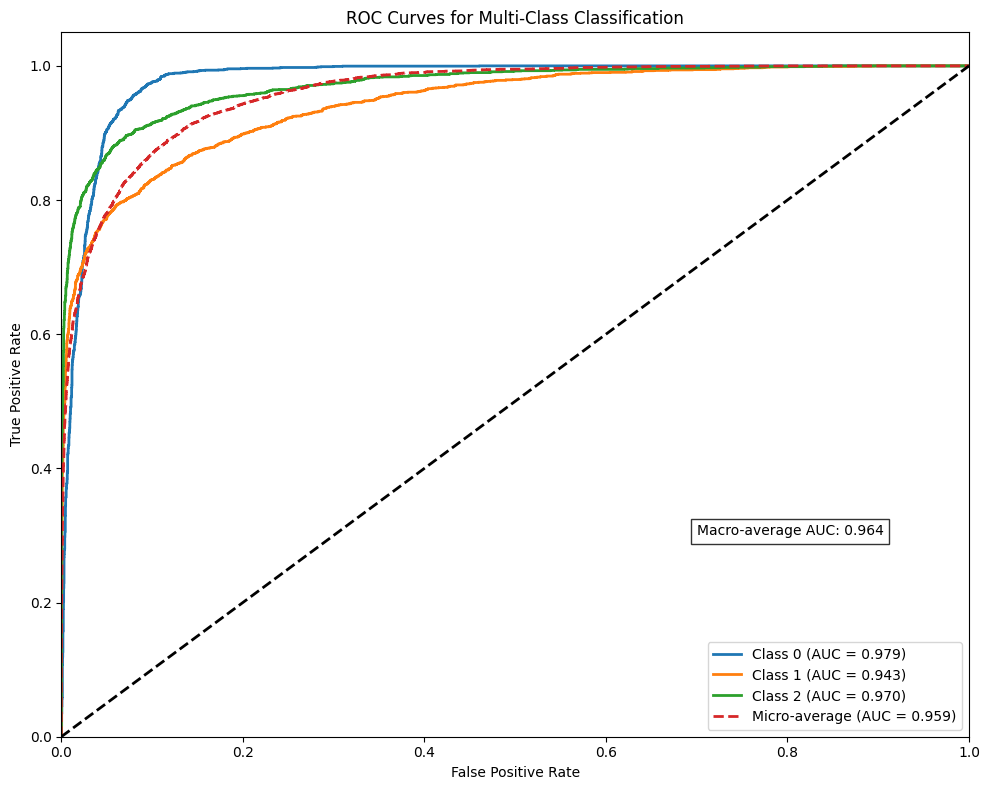


AUC Scores:
------------------------------
Class      | AUC Score 
------------------------------
0          | 0.9789
1          | 0.9428
2          | 0.9700
------------------------------
Micro-avg  | 0.9591
Macro-avg  | 0.9639
[0.9789124399999999, 0.94279016, 0.9699647199999999] 0.9591336266666669 0.9638891066666666


In [15]:

# Now unfreeze the encoder and continue training with a lower learning rate
for param in classifier_model.encoder.parameters():
    param.requires_grad = True

print("Fine-tuning the entire model...")
classifier_model = train_classifier(classifier_model, train_loader_cls, val_loader_cls, num_epochs=50, device=device)


class_auc_scores, micro_auc, macro_auc = visualize_classifier_roc_auc(
    classifier_model, 
    val_loader_cls,
    num_classes=3, 
    device=device
)

print(class_auc_scores, micro_auc, macro_auc)

Starting AutoMAE training with learnable masking...


Epoch 1/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 23.96it/s]


[AutoMAE] Epoch [1/50], Recon Loss: 0.254080, Mask Loss: -0.025408, Total Loss: -0.025408, Mode: Mask Update


Epoch 2/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 24.93it/s]


[AutoMAE] Epoch [2/50], Recon Loss: 0.254251, Mask Loss: -0.025425, Total Loss: -0.025425, Mode: Mask Update


Epoch 3/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.89it/s]


[AutoMAE] Epoch [3/50], Recon Loss: 0.018603, Mask Loss: -0.001860, Total Loss: 0.018603, Mode: MAE Update


Epoch 4/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.96it/s]


[AutoMAE] Epoch [4/50], Recon Loss: 0.001728, Mask Loss: -0.000173, Total Loss: 0.001728, Mode: MAE Update


Epoch 5/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.07it/s]


[AutoMAE] Epoch [5/50], Recon Loss: 0.001731, Mask Loss: -0.000173, Total Loss: -0.000173, Mode: Mask Update


Epoch 6/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 24.79it/s]


[AutoMAE] Epoch [6/50], Recon Loss: 0.001709, Mask Loss: -0.000171, Total Loss: -0.000171, Mode: Mask Update


Epoch 7/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.91it/s]


[AutoMAE] Epoch [7/50], Recon Loss: 0.001291, Mask Loss: -0.000129, Total Loss: 0.001291, Mode: MAE Update


Epoch 8/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 25.08it/s]


[AutoMAE] Epoch [8/50], Recon Loss: 0.001100, Mask Loss: -0.000110, Total Loss: 0.001100, Mode: MAE Update


Epoch 9/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.09it/s]


[AutoMAE] Epoch [9/50], Recon Loss: 0.001053, Mask Loss: -0.000105, Total Loss: -0.000105, Mode: Mask Update


Epoch 10/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 24.92it/s]


[AutoMAE] Epoch [10/50], Recon Loss: 0.001065, Mask Loss: -0.000107, Total Loss: -0.000107, Mode: Mask Update


Epoch 11/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.79it/s]


[AutoMAE] Epoch [11/50], Recon Loss: 0.001010, Mask Loss: -0.000101, Total Loss: 0.001010, Mode: MAE Update


Epoch 12/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 25.15it/s]


[AutoMAE] Epoch [12/50], Recon Loss: 0.000922, Mask Loss: -0.000092, Total Loss: 0.000922, Mode: MAE Update


Epoch 13/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.05it/s]


[AutoMAE] Epoch [13/50], Recon Loss: 0.000920, Mask Loss: -0.000092, Total Loss: -0.000092, Mode: Mask Update


Epoch 14/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.13it/s]


[AutoMAE] Epoch [14/50], Recon Loss: 0.000941, Mask Loss: -0.000094, Total Loss: -0.000094, Mode: Mask Update


Epoch 15/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.81it/s]


[AutoMAE] Epoch [15/50], Recon Loss: 0.000897, Mask Loss: -0.000090, Total Loss: 0.000897, Mode: MAE Update


Epoch 16/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.59it/s]


[AutoMAE] Epoch [16/50], Recon Loss: 0.000850, Mask Loss: -0.000085, Total Loss: 0.000850, Mode: MAE Update


Epoch 17/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 24.89it/s]


[AutoMAE] Epoch [17/50], Recon Loss: 0.000899, Mask Loss: -0.000090, Total Loss: -0.000090, Mode: Mask Update


Epoch 18/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.00it/s]


[AutoMAE] Epoch [18/50], Recon Loss: 0.000882, Mask Loss: -0.000088, Total Loss: -0.000088, Mode: Mask Update


Epoch 19/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.99it/s]


[AutoMAE] Epoch [19/50], Recon Loss: 0.000858, Mask Loss: -0.000086, Total Loss: 0.000858, Mode: MAE Update


Epoch 20/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.90it/s]


[AutoMAE] Epoch [20/50], Recon Loss: 0.000825, Mask Loss: -0.000082, Total Loss: 0.000825, Mode: MAE Update


Epoch 21/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 24.69it/s]


[AutoMAE] Epoch [21/50], Recon Loss: 0.000754, Mask Loss: -0.000075, Total Loss: -0.000075, Mode: Mask Update


Epoch 22/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.16it/s]


[AutoMAE] Epoch [22/50], Recon Loss: 0.000771, Mask Loss: -0.000077, Total Loss: -0.000077, Mode: Mask Update


Epoch 23/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.88it/s]


[AutoMAE] Epoch [23/50], Recon Loss: 0.000793, Mask Loss: -0.000079, Total Loss: 0.000793, Mode: MAE Update


Epoch 24/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 25.04it/s]


[AutoMAE] Epoch [24/50], Recon Loss: 0.000773, Mask Loss: -0.000077, Total Loss: 0.000773, Mode: MAE Update


Epoch 25/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.02it/s]


[AutoMAE] Epoch [25/50], Recon Loss: 0.000811, Mask Loss: -0.000081, Total Loss: -0.000081, Mode: Mask Update


Epoch 26/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 24.88it/s]


[AutoMAE] Epoch [26/50], Recon Loss: 0.000804, Mask Loss: -0.000080, Total Loss: -0.000080, Mode: Mask Update


Epoch 27/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.79it/s]


[AutoMAE] Epoch [27/50], Recon Loss: 0.000764, Mask Loss: -0.000076, Total Loss: 0.000764, Mode: MAE Update


Epoch 28/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.93it/s]


[AutoMAE] Epoch [28/50], Recon Loss: 0.000740, Mask Loss: -0.000074, Total Loss: 0.000740, Mode: MAE Update


Epoch 29/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.35it/s]


[AutoMAE] Epoch [29/50], Recon Loss: 0.000740, Mask Loss: -0.000074, Total Loss: -0.000074, Mode: Mask Update


Epoch 30/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.45it/s]


[AutoMAE] Epoch [30/50], Recon Loss: 0.000740, Mask Loss: -0.000074, Total Loss: -0.000074, Mode: Mask Update


Epoch 31/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.84it/s]


[AutoMAE] Epoch [31/50], Recon Loss: 0.000740, Mask Loss: -0.000074, Total Loss: 0.000740, Mode: MAE Update


Epoch 32/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.97it/s]


[AutoMAE] Epoch [32/50], Recon Loss: 0.000734, Mask Loss: -0.000073, Total Loss: 0.000734, Mode: MAE Update


Epoch 33/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.22it/s]


[AutoMAE] Epoch [33/50], Recon Loss: 0.000870, Mask Loss: -0.000087, Total Loss: -0.000087, Mode: Mask Update


Epoch 34/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.23it/s]


[AutoMAE] Epoch [34/50], Recon Loss: 0.000896, Mask Loss: -0.000090, Total Loss: -0.000090, Mode: Mask Update


Epoch 35/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 25.03it/s]


[AutoMAE] Epoch [35/50], Recon Loss: 0.000704, Mask Loss: -0.000070, Total Loss: 0.000704, Mode: MAE Update


Epoch 36/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.84it/s]


[AutoMAE] Epoch [36/50], Recon Loss: 0.000686, Mask Loss: -0.000069, Total Loss: 0.000686, Mode: MAE Update


Epoch 37/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.14it/s]


[AutoMAE] Epoch [37/50], Recon Loss: 0.000702, Mask Loss: -0.000070, Total Loss: -0.000070, Mode: Mask Update


Epoch 38/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.42it/s]


[AutoMAE] Epoch [38/50], Recon Loss: 0.000708, Mask Loss: -0.000071, Total Loss: -0.000071, Mode: Mask Update


Epoch 39/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.98it/s]


[AutoMAE] Epoch [39/50], Recon Loss: 0.000697, Mask Loss: -0.000070, Total Loss: 0.000697, Mode: MAE Update


Epoch 40/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.98it/s]


[AutoMAE] Epoch [40/50], Recon Loss: 0.000687, Mask Loss: -0.000069, Total Loss: 0.000687, Mode: MAE Update


Epoch 41/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 24.95it/s]


[AutoMAE] Epoch [41/50], Recon Loss: 0.000639, Mask Loss: -0.000064, Total Loss: -0.000064, Mode: Mask Update


Epoch 42/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 24.98it/s]


[AutoMAE] Epoch [42/50], Recon Loss: 0.000663, Mask Loss: -0.000066, Total Loss: -0.000066, Mode: Mask Update


Epoch 43/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.90it/s]


[AutoMAE] Epoch [43/50], Recon Loss: 0.000672, Mask Loss: -0.000067, Total Loss: 0.000672, Mode: MAE Update


Epoch 44/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.97it/s]


[AutoMAE] Epoch [44/50], Recon Loss: 0.000665, Mask Loss: -0.000067, Total Loss: 0.000665, Mode: MAE Update


Epoch 45/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.25it/s]


[AutoMAE] Epoch [45/50], Recon Loss: 0.000638, Mask Loss: -0.000064, Total Loss: -0.000064, Mode: Mask Update


Epoch 46/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.08it/s]


[AutoMAE] Epoch [46/50], Recon Loss: 0.000628, Mask Loss: -0.000063, Total Loss: -0.000063, Mode: Mask Update


Epoch 47/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 24.74it/s]


[AutoMAE] Epoch [47/50], Recon Loss: 0.000632, Mask Loss: -0.000063, Total Loss: 0.000632, Mode: MAE Update


Epoch 48/50 - MAE Update: 100%|██████████| 157/157 [00:06<00:00, 25.32it/s]


[AutoMAE] Epoch [48/50], Recon Loss: 0.000654, Mask Loss: -0.000065, Total Loss: 0.000654, Mode: MAE Update


Epoch 49/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.44it/s]


[AutoMAE] Epoch [49/50], Recon Loss: 0.000656, Mask Loss: -0.000066, Total Loss: -0.000066, Mode: Mask Update


Epoch 50/50 - Mask Update: 100%|██████████| 157/157 [00:06<00:00, 25.14it/s]

[AutoMAE] Epoch [50/50], Recon Loss: 0.000648, Mask Loss: -0.000065, Total Loss: -0.000065, Mode: Mask Update


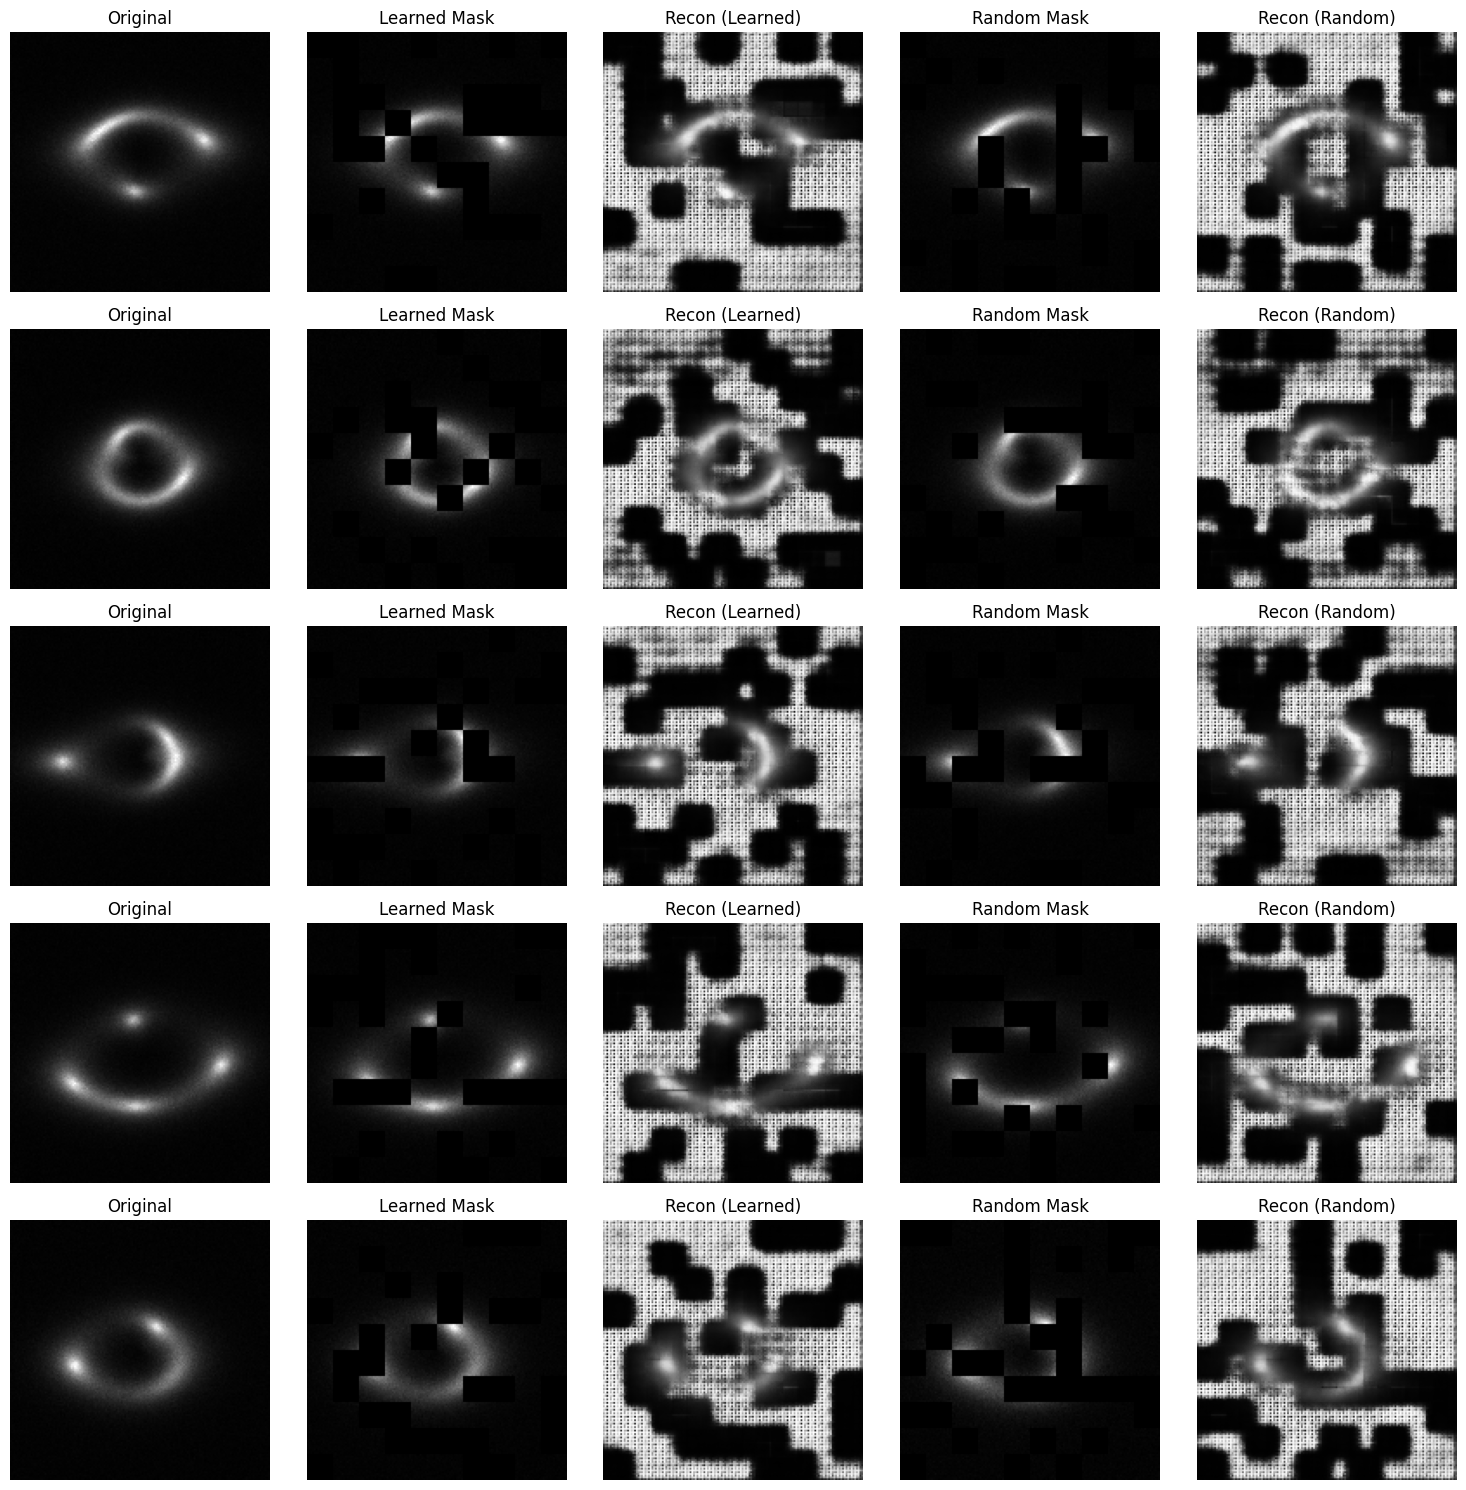

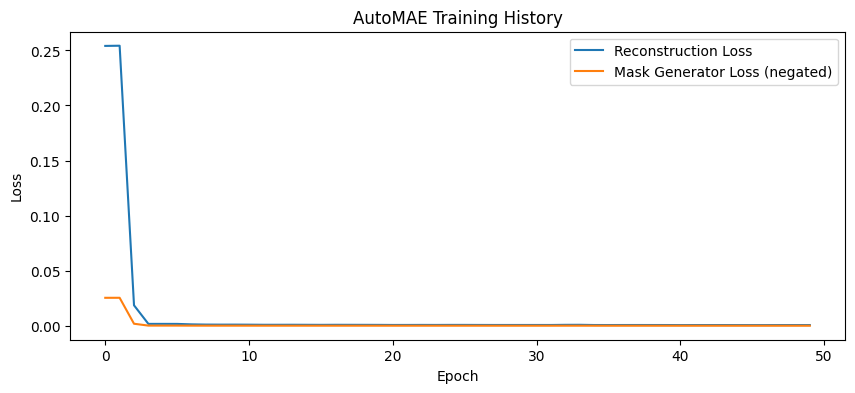

In [16]:
# Initialize the AutoMAE model with learnable masking
automae_model = MAE_LearnMask(in_channels=1, latent_dim=512, patch_size=15)

# Train the model with learnable masking
print("Starting AutoMAE training with learnable masking...")
automae_model = train_mae_learn(
    automae_model, 
    mae_loader, 
    num_epochs=50, 
    device=device, 
    mask_ratio=0.30, 
    patch_size=15,
    alpha=0.1,  # Weight for adversarial loss
    alternate_epochs=2  # Alternate between training modes every 2 epochs
)

# Get the pretrained encoder for downstream tasks
pretrained_encoder = automae_model.encoder

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting classifier fine-tuning with frozen encoder...


Epoch 1/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.98it/s]


[Classifier] Epoch [1/50], Train Loss: 1.1125, Train Acc: 33.34%, Val Loss: 1.1027, Val Acc: 33.73%, ROC AUC: 0.4992


Epoch 2/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.31it/s]


[Classifier] Epoch [2/50], Train Loss: 1.1060, Train Acc: 33.53%, Val Loss: 1.1008, Val Acc: 34.44%, ROC AUC: 0.5147


Epoch 3/50 - Validation: 100%|██████████| 118/118 [00:03<00:00, 36.01it/s]


[Classifier] Epoch [3/50], Train Loss: 1.1014, Train Acc: 35.31%, Val Loss: 1.1629, Val Acc: 34.15%, ROC AUC: 0.5158


Epoch 4/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.08it/s]


[Classifier] Epoch [4/50], Train Loss: 1.0927, Train Acc: 37.56%, Val Loss: 1.1029, Val Acc: 36.11%, ROC AUC: 0.5567


Epoch 5/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.08it/s]


[Classifier] Epoch [5/50], Train Loss: 1.0786, Train Acc: 39.94%, Val Loss: 1.1550, Val Acc: 34.89%, ROC AUC: 0.5375


Epoch 6/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.46it/s]


[Classifier] Epoch [6/50], Train Loss: 1.0581, Train Acc: 42.48%, Val Loss: 1.0779, Val Acc: 39.88%, ROC AUC: 0.5947


Epoch 7/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.77it/s]


[Classifier] Epoch [7/50], Train Loss: 1.0385, Train Acc: 44.27%, Val Loss: 1.0571, Val Acc: 41.68%, ROC AUC: 0.6123


Epoch 8/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.65it/s]


[Classifier] Epoch [8/50], Train Loss: 1.0191, Train Acc: 45.88%, Val Loss: 2.4892, Val Acc: 33.45%, ROC AUC: 0.5785


Epoch 9/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.50it/s]


[Classifier] Epoch [9/50], Train Loss: 1.0033, Train Acc: 47.41%, Val Loss: 1.2280, Val Acc: 34.81%, ROC AUC: 0.5935


Epoch 10/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.67it/s]


[Classifier] Epoch [10/50], Train Loss: 0.9816, Train Acc: 49.11%, Val Loss: 1.9111, Val Acc: 34.35%, ROC AUC: 0.5998


Epoch 11/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.06it/s]


[Classifier] Epoch [11/50], Train Loss: 0.9689, Train Acc: 49.76%, Val Loss: 1.2697, Val Acc: 35.61%, ROC AUC: 0.6270


Epoch 12/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.15it/s]


[Classifier] Epoch [12/50], Train Loss: 0.9567, Train Acc: 51.09%, Val Loss: 1.9413, Val Acc: 33.36%, ROC AUC: 0.5622


Epoch 13/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.40it/s]


[Classifier] Epoch [13/50], Train Loss: 0.9383, Train Acc: 52.22%, Val Loss: 3.3030, Val Acc: 33.36%, ROC AUC: 0.6230


Epoch 14/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.14it/s]


[Classifier] Epoch [14/50], Train Loss: 0.9325, Train Acc: 52.60%, Val Loss: 1.5035, Val Acc: 34.03%, ROC AUC: 0.5890


Epoch 15/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.49it/s]


[Classifier] Epoch [15/50], Train Loss: 0.9236, Train Acc: 53.42%, Val Loss: 3.3282, Val Acc: 33.33%, ROC AUC: 0.5723


Epoch 16/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.68it/s]


[Classifier] Epoch [16/50], Train Loss: 0.8741, Train Acc: 56.83%, Val Loss: 1.0134, Val Acc: 49.65%, ROC AUC: 0.7218


Epoch 17/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.81it/s]


[Classifier] Epoch [17/50], Train Loss: 0.8647, Train Acc: 57.36%, Val Loss: 1.2398, Val Acc: 40.59%, ROC AUC: 0.6695


Epoch 18/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.55it/s]


[Classifier] Epoch [18/50], Train Loss: 0.8555, Train Acc: 57.70%, Val Loss: 0.9009, Val Acc: 54.17%, ROC AUC: 0.7388


Epoch 19/50 - Validation: 100%|██████████| 118/118 [00:03<00:00, 38.51it/s]


[Classifier] Epoch [19/50], Train Loss: 0.8431, Train Acc: 58.42%, Val Loss: 1.1551, Val Acc: 44.61%, ROC AUC: 0.6668


Epoch 20/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.66it/s]


[Classifier] Epoch [20/50], Train Loss: 0.8342, Train Acc: 58.92%, Val Loss: 2.7695, Val Acc: 33.41%, ROC AUC: 0.6496


Epoch 21/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.55it/s]


[Classifier] Epoch [21/50], Train Loss: 0.8290, Train Acc: 59.33%, Val Loss: 1.6771, Val Acc: 37.55%, ROC AUC: 0.6442


Epoch 22/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 39.74it/s]


[Classifier] Epoch [22/50], Train Loss: 0.8182, Train Acc: 59.75%, Val Loss: 1.2975, Val Acc: 41.69%, ROC AUC: 0.6965


Epoch 23/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.70it/s]


[Classifier] Epoch [23/50], Train Loss: 0.7671, Train Acc: 63.17%, Val Loss: 1.2009, Val Acc: 45.69%, ROC AUC: 0.7312
Early stopping triggered after 23 epochs
Loaded best model with AUC: 0.7388


Generating predictions: 100%|██████████| 118/118 [00:02<00:00, 42.19it/s]


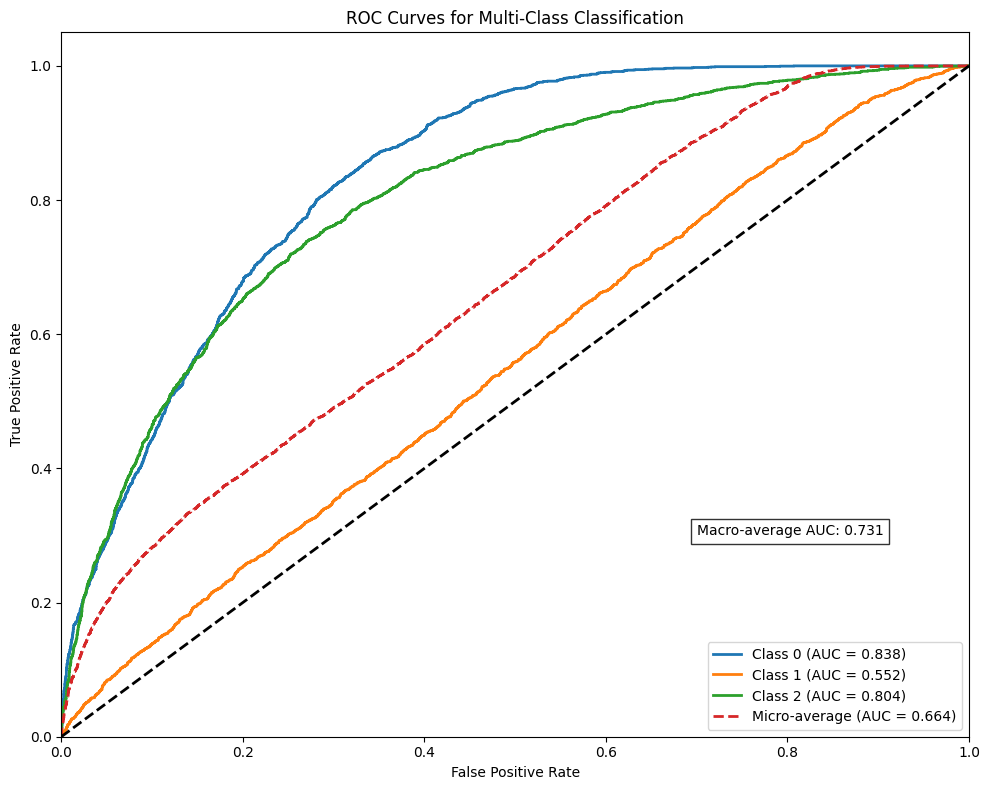

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



AUC Scores:
------------------------------
Class      | AUC Score 
------------------------------
0          | 0.8376
1          | 0.5517
2          | 0.8042
------------------------------
Micro-avg  | 0.6643
Macro-avg  | 0.7312
[0.83762896, 0.5516998799999999, 0.8041732000000001] 0.6642757422222222 0.7311673466666667
Fine-tuning the entire model...


Epoch 1/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.43it/s]


[Classifier] Epoch [1/50], Train Loss: 1.0043, Train Acc: 48.53%, Val Loss: 1.1665, Val Acc: 38.19%, ROC AUC: 0.5944


Epoch 2/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.80it/s]


[Classifier] Epoch [2/50], Train Loss: 0.9191, Train Acc: 54.12%, Val Loss: 1.0245, Val Acc: 48.27%, ROC AUC: 0.7121


Epoch 3/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.65it/s]


[Classifier] Epoch [3/50], Train Loss: 0.8611, Train Acc: 58.16%, Val Loss: 1.6463, Val Acc: 35.21%, ROC AUC: 0.6204


Epoch 4/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.82it/s]


[Classifier] Epoch [4/50], Train Loss: 0.8161, Train Acc: 61.04%, Val Loss: 1.0388, Val Acc: 50.51%, ROC AUC: 0.7606


Epoch 5/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.33it/s]


[Classifier] Epoch [5/50], Train Loss: 0.7660, Train Acc: 64.58%, Val Loss: 1.9362, Val Acc: 39.56%, ROC AUC: 0.7497


Epoch 6/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.50it/s]


[Classifier] Epoch [6/50], Train Loss: 0.7211, Train Acc: 66.91%, Val Loss: 0.8528, Val Acc: 58.72%, ROC AUC: 0.7985


Epoch 7/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.14it/s]


[Classifier] Epoch [7/50], Train Loss: 0.6914, Train Acc: 68.80%, Val Loss: 1.3557, Val Acc: 52.48%, ROC AUC: 0.7961


Epoch 8/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.60it/s]


[Classifier] Epoch [8/50], Train Loss: 0.6609, Train Acc: 70.37%, Val Loss: 3.5573, Val Acc: 33.91%, ROC AUC: 0.6511


Epoch 9/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.28it/s]


[Classifier] Epoch [9/50], Train Loss: 0.6230, Train Acc: 72.71%, Val Loss: 2.4269, Val Acc: 34.67%, ROC AUC: 0.7158


Epoch 10/50 - Validation: 100%|██████████| 118/118 [00:03<00:00, 38.92it/s]


[Classifier] Epoch [10/50], Train Loss: 0.5892, Train Acc: 74.53%, Val Loss: 2.4190, Val Acc: 43.61%, ROC AUC: 0.7588


Epoch 11/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 41.04it/s]


[Classifier] Epoch [11/50], Train Loss: 0.4896, Train Acc: 79.37%, Val Loss: 0.6329, Val Acc: 72.89%, ROC AUC: 0.9075


Epoch 12/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.55it/s]


[Classifier] Epoch [12/50], Train Loss: 0.4596, Train Acc: 80.83%, Val Loss: 0.7097, Val Acc: 70.39%, ROC AUC: 0.8721


Epoch 13/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.17it/s]


[Classifier] Epoch [13/50], Train Loss: 0.4348, Train Acc: 81.92%, Val Loss: 0.8060, Val Acc: 67.24%, ROC AUC: 0.8658


Epoch 14/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.99it/s]


[Classifier] Epoch [14/50], Train Loss: 0.4144, Train Acc: 83.09%, Val Loss: 1.1931, Val Acc: 64.56%, ROC AUC: 0.8553


Epoch 15/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.36it/s]


[Classifier] Epoch [15/50], Train Loss: 0.3954, Train Acc: 83.98%, Val Loss: 1.3402, Val Acc: 53.44%, ROC AUC: 0.8373


Epoch 16/50 - Validation: 100%|██████████| 118/118 [00:02<00:00, 40.80it/s]


[Classifier] Epoch [16/50], Train Loss: 0.3092, Train Acc: 87.89%, Val Loss: 1.1210, Val Acc: 63.48%, ROC AUC: 0.8761
Early stopping triggered after 16 epochs
Loaded best model with AUC: 0.9075


Generating predictions: 100%|██████████| 118/118 [00:02<00:00, 41.56it/s]


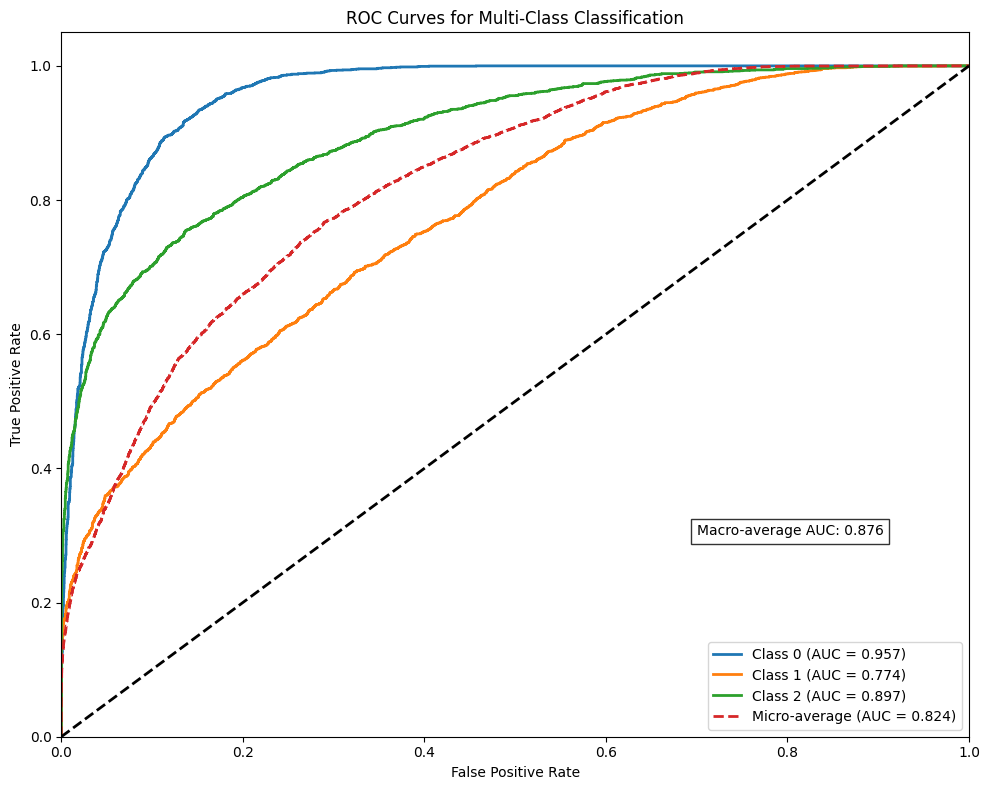


AUC Scores:
------------------------------
Class      | AUC Score 
------------------------------
0          | 0.9574
1          | 0.7741
2          | 0.8969
------------------------------
Micro-avg  | 0.8245
Macro-avg  | 0.8761
[0.9573611999999999, 0.774052, 0.8969344] 0.82447368 0.8761158666666667


In [17]:

# 6A task

# Full dataset paths for training and validation
train_dir = '/kaggle/input/deeplense-lensing-classes/dataset/train'
val_dir   = '/kaggle/input/deeplense-lensing-classes/dataset/val'
dataset_train = NpyImageDataset(train_dir, transform=transform)
dataset_val   = NpyImageDataset(val_dir, transform=transform)
train_loader_cls = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=4)
val_loader_cls   = DataLoader(dataset_val, batch_size=64, shuffle=False, num_workers=4)

# Build improved classification model using the pretrained encoder
classifier_model = ClassificationModel(encoder=pretrained_encoder, latent_dim=512, num_classes=3)

# Freeze the encoder for a few epochs to allow the new layers to adapt
for param in classifier_model.encoder.parameters():
    param.requires_grad = False

print("Starting classifier fine-tuning with frozen encoder...")
classifier_model = train_classifier(classifier_model, train_loader_cls, val_loader_cls, num_epochs=50, device=device)

class_auc_scores, micro_auc, macro_auc = visualize_classifier_roc_auc(
    classifier_model, 
    val_loader_cls,
    num_classes=3, 
    device=device
)

print(class_auc_scores, micro_auc, macro_auc)

# Now unfreeze the encoder and continue training with a lower learning rate
for param in classifier_model.encoder.parameters():
    param.requires_grad = True

print("Fine-tuning the entire model...")
classifier_model = train_classifier(classifier_model, train_loader_cls, val_loader_cls, num_epochs=50, device=device)


class_auc_scores, micro_auc, macro_auc = visualize_classifier_roc_auc(
    classifier_model, 
    val_loader_cls,
    num_classes=3, 
    device=device
)

print(class_auc_scores, micro_auc, macro_auc)


Starting super-resolution fine-tuning...


Epoch 1/50: 100%|██████████| 157/157 [00:37<00:00,  4.23it/s]


[Super-Resolution] Epoch [1/50], MSE Loss: 0.024729, L1 Loss: 0.118545, Total Loss: 0.084002, PSNR: 16.07 dB


Epoch 2/50: 100%|██████████| 157/157 [00:06<00:00, 24.28it/s]


[Super-Resolution] Epoch [2/50], MSE Loss: 0.000377, L1 Loss: 0.013940, Total Loss: 0.007347, PSNR: 34.23 dB


Epoch 3/50: 100%|██████████| 157/157 [00:06<00:00, 24.73it/s]


[Super-Resolution] Epoch [3/50], MSE Loss: 0.000149, L1 Loss: 0.006929, Total Loss: 0.003614, PSNR: 38.26 dB


Epoch 4/50: 100%|██████████| 157/157 [00:06<00:00, 24.70it/s]


[Super-Resolution] Epoch [4/50], MSE Loss: 0.000118, L1 Loss: 0.006255, Total Loss: 0.003245, PSNR: 39.30 dB


Epoch 5/50: 100%|██████████| 157/157 [00:06<00:00, 24.69it/s]


[Super-Resolution] Epoch [5/50], MSE Loss: 0.000115, L1 Loss: 0.006225, Total Loss: 0.003227, PSNR: 39.41 dB


Epoch 6/50: 100%|██████████| 157/157 [00:06<00:00, 24.23it/s]


[Super-Resolution] Epoch [6/50], MSE Loss: 0.000110, L1 Loss: 0.006159, Total Loss: 0.003190, PSNR: 39.58 dB


Epoch 7/50: 100%|██████████| 157/157 [00:06<00:00, 24.56it/s]


[Super-Resolution] Epoch [7/50], MSE Loss: 0.000104, L1 Loss: 0.006046, Total Loss: 0.003127, PSNR: 39.84 dB


Epoch 8/50: 100%|██████████| 157/157 [00:06<00:00, 24.91it/s]


[Super-Resolution] Epoch [8/50], MSE Loss: 0.000102, L1 Loss: 0.006022, Total Loss: 0.003113, PSNR: 39.91 dB


Epoch 9/50: 100%|██████████| 157/157 [00:06<00:00, 24.55it/s]


[Super-Resolution] Epoch [9/50], MSE Loss: 0.000101, L1 Loss: 0.006012, Total Loss: 0.003107, PSNR: 39.95 dB


Epoch 10/50: 100%|██████████| 157/157 [00:06<00:00, 25.09it/s]


[Super-Resolution] Epoch [10/50], MSE Loss: 0.000099, L1 Loss: 0.005972, Total Loss: 0.003085, PSNR: 40.04 dB


Epoch 11/50: 100%|██████████| 157/157 [00:06<00:00, 24.83it/s]


[Super-Resolution] Epoch [11/50], MSE Loss: 0.000099, L1 Loss: 0.005974, Total Loss: 0.003086, PSNR: 40.04 dB


Epoch 12/50: 100%|██████████| 157/157 [00:06<00:00, 24.71it/s]


[Super-Resolution] Epoch [12/50], MSE Loss: 0.000099, L1 Loss: 0.005972, Total Loss: 0.003085, PSNR: 40.05 dB


Epoch 13/50: 100%|██████████| 157/157 [00:06<00:00, 24.68it/s]


[Super-Resolution] Epoch [13/50], MSE Loss: 0.000097, L1 Loss: 0.005935, Total Loss: 0.003064, PSNR: 40.14 dB


Epoch 14/50: 100%|██████████| 157/157 [00:06<00:00, 24.33it/s]


[Super-Resolution] Epoch [14/50], MSE Loss: 0.000098, L1 Loss: 0.005968, Total Loss: 0.003083, PSNR: 40.07 dB


Epoch 15/50: 100%|██████████| 157/157 [00:06<00:00, 24.57it/s]


[Super-Resolution] Epoch [15/50], MSE Loss: 0.000096, L1 Loss: 0.005915, Total Loss: 0.003053, PSNR: 40.19 dB


Epoch 16/50: 100%|██████████| 157/157 [00:06<00:00, 24.46it/s]


[Super-Resolution] Epoch [16/50], MSE Loss: 0.000095, L1 Loss: 0.005899, Total Loss: 0.003044, PSNR: 40.23 dB


Epoch 17/50: 100%|██████████| 157/157 [00:06<00:00, 23.35it/s]


[Super-Resolution] Epoch [17/50], MSE Loss: 0.000095, L1 Loss: 0.005904, Total Loss: 0.003047, PSNR: 40.22 dB


Epoch 18/50: 100%|██████████| 157/157 [00:06<00:00, 24.72it/s]


[Super-Resolution] Epoch [18/50], MSE Loss: 0.000095, L1 Loss: 0.005900, Total Loss: 0.003045, PSNR: 40.23 dB


Epoch 19/50: 100%|██████████| 157/157 [00:06<00:00, 24.61it/s]


[Super-Resolution] Epoch [19/50], MSE Loss: 0.000094, L1 Loss: 0.005894, Total Loss: 0.003042, PSNR: 40.25 dB


Epoch 20/50: 100%|██████████| 157/157 [00:06<00:00, 24.69it/s]


[Super-Resolution] Epoch [20/50], MSE Loss: 0.000094, L1 Loss: 0.005893, Total Loss: 0.003041, PSNR: 40.25 dB


Epoch 21/50: 100%|██████████| 157/157 [00:06<00:00, 24.08it/s]


[Super-Resolution] Epoch [21/50], MSE Loss: 0.000095, L1 Loss: 0.005896, Total Loss: 0.003043, PSNR: 40.24 dB


Epoch 22/50: 100%|██████████| 157/157 [00:06<00:00, 24.14it/s]


[Super-Resolution] Epoch [22/50], MSE Loss: 0.000095, L1 Loss: 0.005901, Total Loss: 0.003045, PSNR: 40.23 dB


Epoch 23/50: 100%|██████████| 157/157 [00:06<00:00, 24.55it/s]


[Super-Resolution] Epoch [23/50], MSE Loss: 0.000094, L1 Loss: 0.005886, Total Loss: 0.003037, PSNR: 40.27 dB


Epoch 24/50: 100%|██████████| 157/157 [00:06<00:00, 24.55it/s]


[Super-Resolution] Epoch [24/50], MSE Loss: 0.000094, L1 Loss: 0.005880, Total Loss: 0.003034, PSNR: 40.28 dB


Epoch 25/50: 100%|██████████| 157/157 [00:06<00:00, 24.52it/s]


[Super-Resolution] Epoch [25/50], MSE Loss: 0.000093, L1 Loss: 0.005876, Total Loss: 0.003031, PSNR: 40.29 dB


Epoch 26/50: 100%|██████████| 157/157 [00:06<00:00, 24.46it/s]


[Super-Resolution] Epoch [26/50], MSE Loss: 0.000094, L1 Loss: 0.005885, Total Loss: 0.003036, PSNR: 40.27 dB


Epoch 27/50: 100%|██████████| 157/157 [00:06<00:00, 24.27it/s]


[Super-Resolution] Epoch [27/50], MSE Loss: 0.000094, L1 Loss: 0.005884, Total Loss: 0.003036, PSNR: 40.27 dB


Epoch 28/50: 100%|██████████| 157/157 [00:06<00:00, 24.66it/s]


[Super-Resolution] Epoch [28/50], MSE Loss: 0.000094, L1 Loss: 0.005884, Total Loss: 0.003036, PSNR: 40.27 dB


Epoch 29/50: 100%|██████████| 157/157 [00:06<00:00, 24.50it/s]


[Super-Resolution] Epoch [29/50], MSE Loss: 0.000094, L1 Loss: 0.005877, Total Loss: 0.003032, PSNR: 40.29 dB


Epoch 30/50: 100%|██████████| 157/157 [00:06<00:00, 24.60it/s]


[Super-Resolution] Epoch [30/50], MSE Loss: 0.000093, L1 Loss: 0.005874, Total Loss: 0.003030, PSNR: 40.30 dB


Epoch 31/50: 100%|██████████| 157/157 [00:06<00:00, 24.56it/s]


[Super-Resolution] Epoch [31/50], MSE Loss: 0.000094, L1 Loss: 0.005879, Total Loss: 0.003033, PSNR: 40.28 dB


Epoch 32/50: 100%|██████████| 157/157 [00:06<00:00, 23.36it/s]


[Super-Resolution] Epoch [32/50], MSE Loss: 0.000093, L1 Loss: 0.005876, Total Loss: 0.003031, PSNR: 40.29 dB


Epoch 33/50: 100%|██████████| 157/157 [00:06<00:00, 24.47it/s]


[Super-Resolution] Epoch [33/50], MSE Loss: 0.000094, L1 Loss: 0.005877, Total Loss: 0.003032, PSNR: 40.29 dB


Epoch 34/50: 100%|██████████| 157/157 [00:06<00:00, 24.54it/s]


[Super-Resolution] Epoch [34/50], MSE Loss: 0.000094, L1 Loss: 0.005884, Total Loss: 0.003036, PSNR: 40.27 dB


Epoch 35/50: 100%|██████████| 157/157 [00:06<00:00, 24.49it/s]


[Super-Resolution] Epoch [35/50], MSE Loss: 0.000093, L1 Loss: 0.005875, Total Loss: 0.003031, PSNR: 40.29 dB


Epoch 36/50: 100%|██████████| 157/157 [00:06<00:00, 24.55it/s]


[Super-Resolution] Epoch [36/50], MSE Loss: 0.000093, L1 Loss: 0.005877, Total Loss: 0.003032, PSNR: 40.29 dB


Epoch 37/50: 100%|██████████| 157/157 [00:06<00:00, 22.80it/s]


[Super-Resolution] Epoch [37/50], MSE Loss: 0.000094, L1 Loss: 0.005879, Total Loss: 0.003033, PSNR: 40.29 dB


Epoch 38/50: 100%|██████████| 157/157 [00:06<00:00, 24.52it/s]


[Super-Resolution] Epoch [38/50], MSE Loss: 0.000093, L1 Loss: 0.005870, Total Loss: 0.003028, PSNR: 40.31 dB


Epoch 39/50: 100%|██████████| 157/157 [00:06<00:00, 24.53it/s]


[Super-Resolution] Epoch [39/50], MSE Loss: 0.000094, L1 Loss: 0.005879, Total Loss: 0.003033, PSNR: 40.29 dB


Epoch 40/50: 100%|██████████| 157/157 [00:06<00:00, 24.44it/s]


[Super-Resolution] Epoch [40/50], MSE Loss: 0.000093, L1 Loss: 0.005872, Total Loss: 0.003029, PSNR: 40.30 dB


Epoch 41/50: 100%|██████████| 157/157 [00:06<00:00, 24.43it/s]


[Super-Resolution] Epoch [41/50], MSE Loss: 0.000093, L1 Loss: 0.005876, Total Loss: 0.003031, PSNR: 40.30 dB


Epoch 42/50: 100%|██████████| 157/157 [00:06<00:00, 22.74it/s]


[Super-Resolution] Epoch [42/50], MSE Loss: 0.000093, L1 Loss: 0.005875, Total Loss: 0.003031, PSNR: 40.30 dB


Epoch 43/50: 100%|██████████| 157/157 [00:06<00:00, 24.69it/s]


[Super-Resolution] Epoch [43/50], MSE Loss: 0.000093, L1 Loss: 0.005868, Total Loss: 0.003027, PSNR: 40.32 dB


Epoch 44/50: 100%|██████████| 157/157 [00:06<00:00, 24.44it/s]


[Super-Resolution] Epoch [44/50], MSE Loss: 0.000094, L1 Loss: 0.005880, Total Loss: 0.003034, PSNR: 40.28 dB


Epoch 45/50: 100%|██████████| 157/157 [00:06<00:00, 24.54it/s]


[Super-Resolution] Epoch [45/50], MSE Loss: 0.000094, L1 Loss: 0.005880, Total Loss: 0.003034, PSNR: 40.28 dB


Epoch 46/50: 100%|██████████| 157/157 [00:06<00:00, 24.58it/s]


[Super-Resolution] Epoch [46/50], MSE Loss: 0.000093, L1 Loss: 0.005873, Total Loss: 0.003030, PSNR: 40.30 dB


Epoch 47/50: 100%|██████████| 157/157 [00:06<00:00, 22.59it/s]


[Super-Resolution] Epoch [47/50], MSE Loss: 0.000093, L1 Loss: 0.005875, Total Loss: 0.003031, PSNR: 40.29 dB


Epoch 48/50: 100%|██████████| 157/157 [00:06<00:00, 24.46it/s]


[Super-Resolution] Epoch [48/50], MSE Loss: 0.000094, L1 Loss: 0.005880, Total Loss: 0.003034, PSNR: 40.28 dB


Epoch 49/50: 100%|██████████| 157/157 [00:06<00:00, 23.47it/s]


[Super-Resolution] Epoch [49/50], MSE Loss: 0.000094, L1 Loss: 0.005878, Total Loss: 0.003033, PSNR: 40.29 dB


Epoch 50/50: 100%|██████████| 157/157 [00:06<00:00, 24.33it/s]

[Super-Resolution] Epoch [50/50], MSE Loss: 0.000094, L1 Loss: 0.005880, Total Loss: 0.003034, PSNR: 40.29 dB


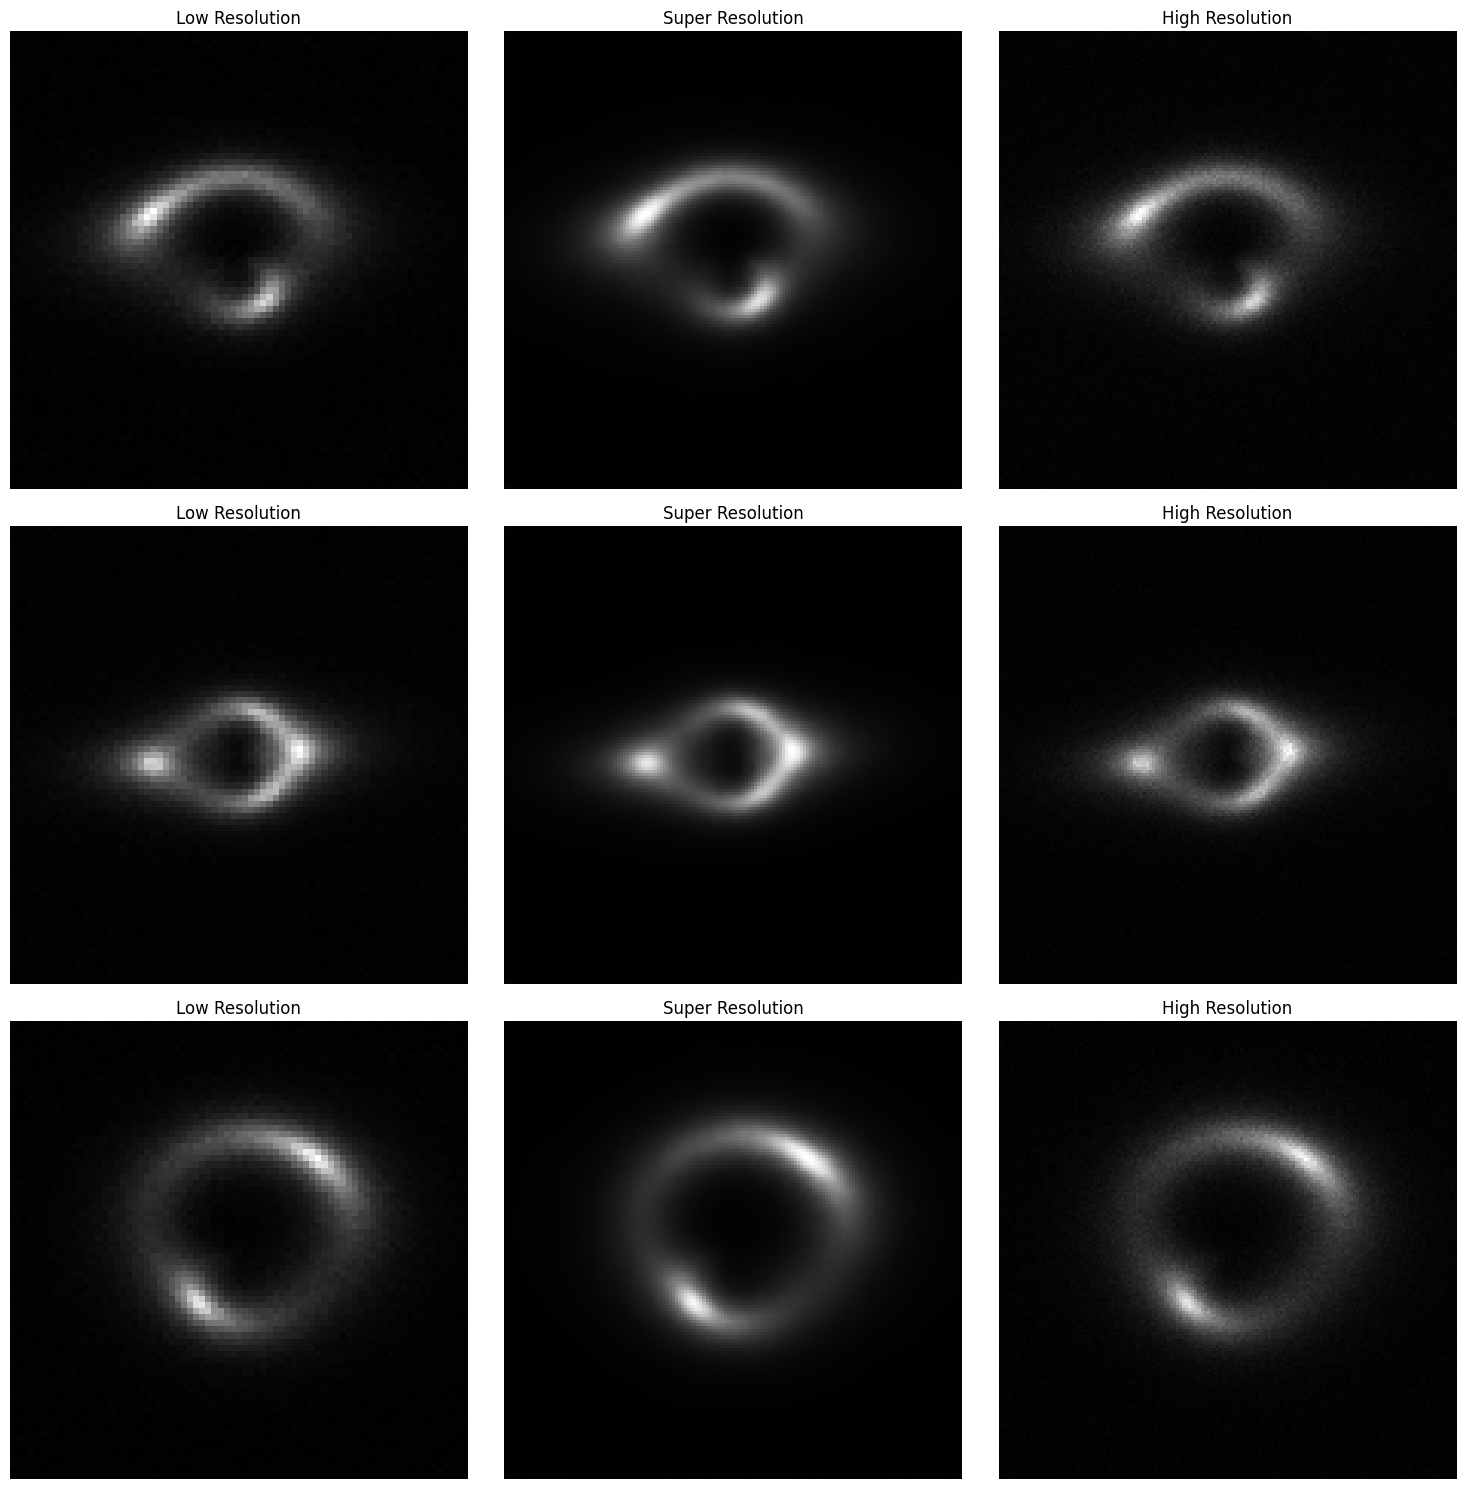

<Figure size 640x480 with 0 Axes>

In [18]:

## 6B task

# Directories for low-resolution (LR) and high-resolution (HR) images.
lr_dir = '/kaggle/input/deeplense-superres-dataset/Dataset/LR'
hr_dir = '/kaggle/input/deeplense-superres-dataset/Dataset/HR'
sr_dataset = NpySuperResolutionDataset(lr_dir, hr_dir, transform_lr=transform, transform_hr=transform)
sr_loader = DataLoader(sr_dataset, batch_size=64, shuffle=True, num_workers=4)

# Build improved super-resolution model using the pretrained encoder
sr_model = SuperResolutionModel(encoder=pretrained_encoder, latent_dim=512, in_channels=1)
print("Starting super-resolution fine-tuning...")
sr_model = train_super_resolution(sr_model, sr_loader, num_epochs=50, device=device)


In [19]:
  
#saving the final models
torch.save(mae_model.state_dict(), 'mae_model.pth')
torch.save(classifier_model.state_dict(), 'classifier_model.pth')
torch.save(sr_model.state_dict(), 'superres_model.pth')
torch.save(automae_model.state_dict(), 'automae_model.pth')

print("Training complete.")

Training complete.
